## Epidemic Modeling

Cerchiamo ora di comprendere come un network di citazioni sia studiabile con un approccio epidemiologico. 
Adottiamo i modelli diffusi SI/SIS/SIR per capire in che modo le citazioni tra paper si evolvono. Questo fenomeno, così studiato, permette di capire in che modo alcuni paper hanno effetti più dirompenti sulla ricerca e come influenzano la produzione scientifica successiva; può aiutare a comprendere in che modo allocare le risorse all'interno di archivi, studiando pattern ricorrenti tra citazioni e adottandoli anche agli eventuali nodi lasciati fuori dal grafo; può poi servire per comprendere se, all'interno della letteratura scientifica, alcune produzioni possono essere poi sempre prese meno in considerazione.

#### S: paper che non hanno ancora citato una determinata pubblicazione, che riscuote successo all'interno del network al variare del tempo
#### I: paper che hanno citato una pubblicazionea
#### R: paper che hanno in precedenza citato una pubblicazione ma che non richiamano più.

In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.viz.mpl.DiffusionTrend as dt
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from tkinter import ttk

import os
import imageio
import shutil

no display found. Using non-interactive Agg backend


In [2]:
def read_custom_edgelist(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                u, v = parts[:2]
                G.add_edge(u, v)
    return G

G = read_custom_edgelist('cit-HepTh_2.edges')

In [3]:
average_degree = sum(dict(G.degree()).values()) / len(G)

In [4]:
infection_rate = 0.3 / average_degree 
recovery_rate = 0.1 * nx.average_clustering(G)  

In [34]:
def configure_model(graph, model, parameters):
    config = mc.Configuration()
    config.add_model_parameter('beta', parameters['beta'])
    if 'gamma' in parameters:
        config.add_model_parameter('gamma', parameters['gamma'])
    config.add_model_initial_configuration("Infected", parameters['initial_infected'])
    model.set_initial_status(config)

In [62]:
def run_simulation(initial_infected, beta=0.1, gamma=0.1, percentage_infected=0.01, iterations_count=100):
    directory = f'frames_{initial_infected}'
    os.makedirs(directory, exist_ok=True)
    plt.plot([0, 1, 2, 3], [initial_infected, beta, gamma, percentage_infected])  # Replace with actual simulation data

## SI Model: 
In questo modello, possiamo osservare come una certa pubblicazione esercita la sua influenza su altri nodi, osservando in che modo cresce il tasso di "infected". 

In [63]:
model = ep.SIModel(G)

In [64]:
model.available_statuses

{'Susceptible': 0, 'Infected': 1}

In [65]:
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta) # infection rate
cfg.add_model_parameter("percentage_infected", percentage_infected)
model.set_initial_status(cfg)

In [66]:
iterations = model.iteration_bunch(100, node_status=True)
trends = model.build_trends(iterations)

In [67]:
plt.close('all')
plt.switch_backend('TkAgg')

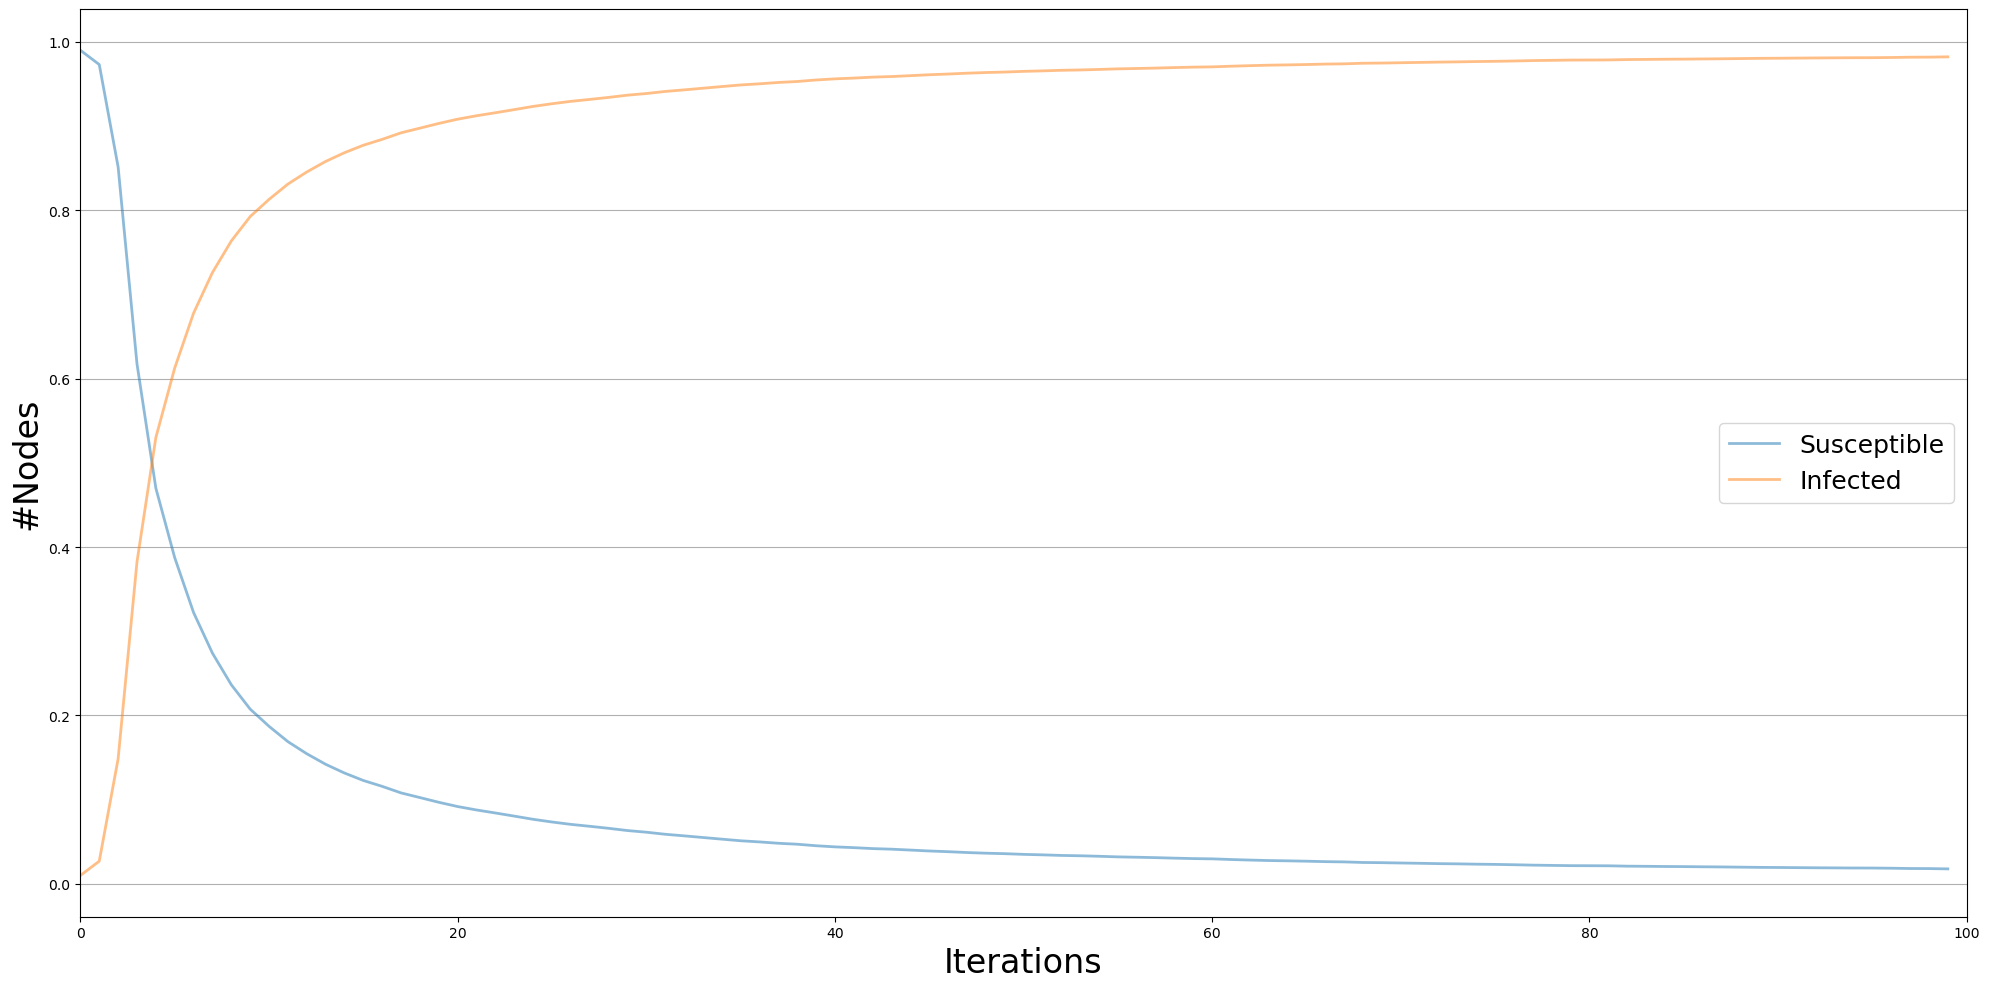

In [68]:
%matplotlib inline
viz = DiffusionTrend(model, trends)
viz.plot()

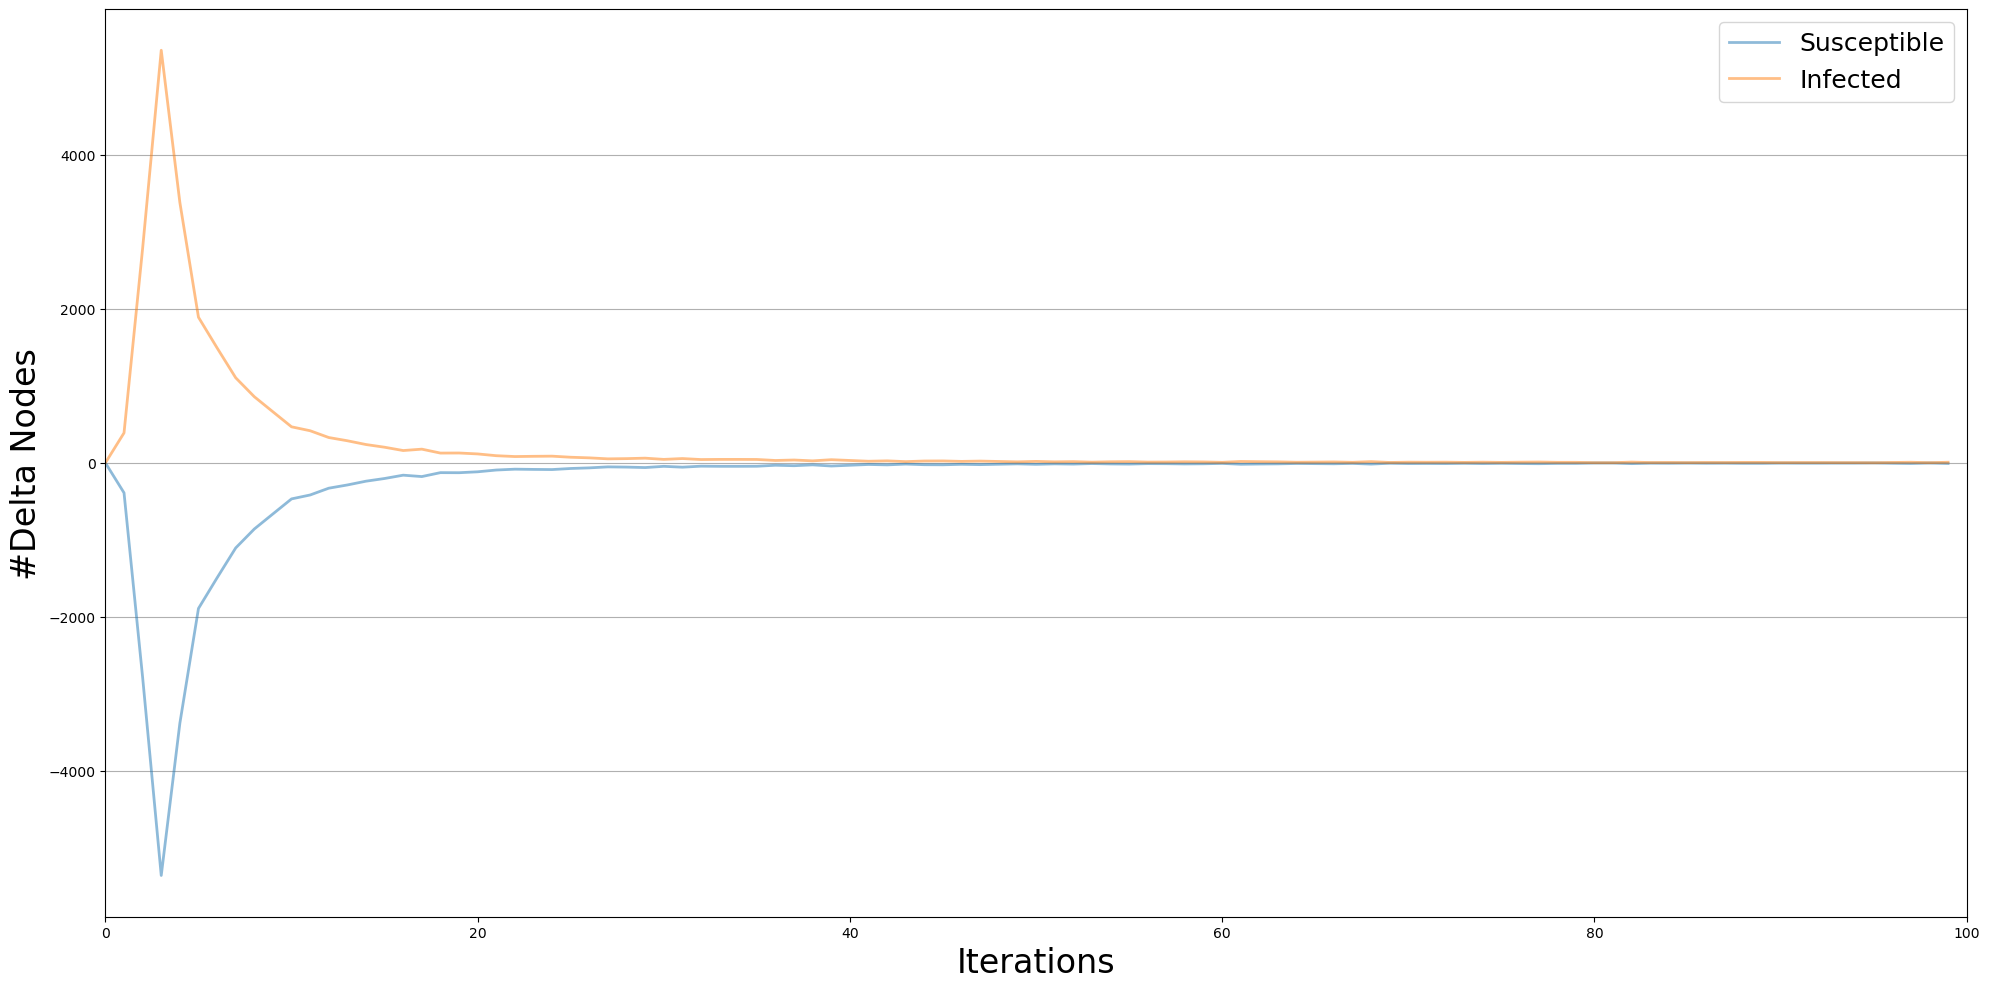

In [69]:
viz = DiffusionPrevalence(model, trends)
viz.plot()

## SIS Model: 
In questo modello, possiamo osservare il comportamento del passaggio tra trasmissione di informazioni e ritorno verso la fonte "suscettibile", per un sistema di citazioni reciproco senza fasi di "ricovero". 

In [44]:
model2 = ep.SISModel(G)

In [45]:
model2.available_statuses

{'Susceptible': 0, 'Infected': 1}

In [46]:
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) # infection rate
cfg.add_model_parameter('lambda', 0.005) # recovery rate
cfg.add_model_parameter("percentage_infected", 0.01)
model2.set_initial_status(cfg)

In [47]:
iterations2 = model2.iteration_bunch(100, node_status=True)
trends2 = model2.build_trends(iterations2)

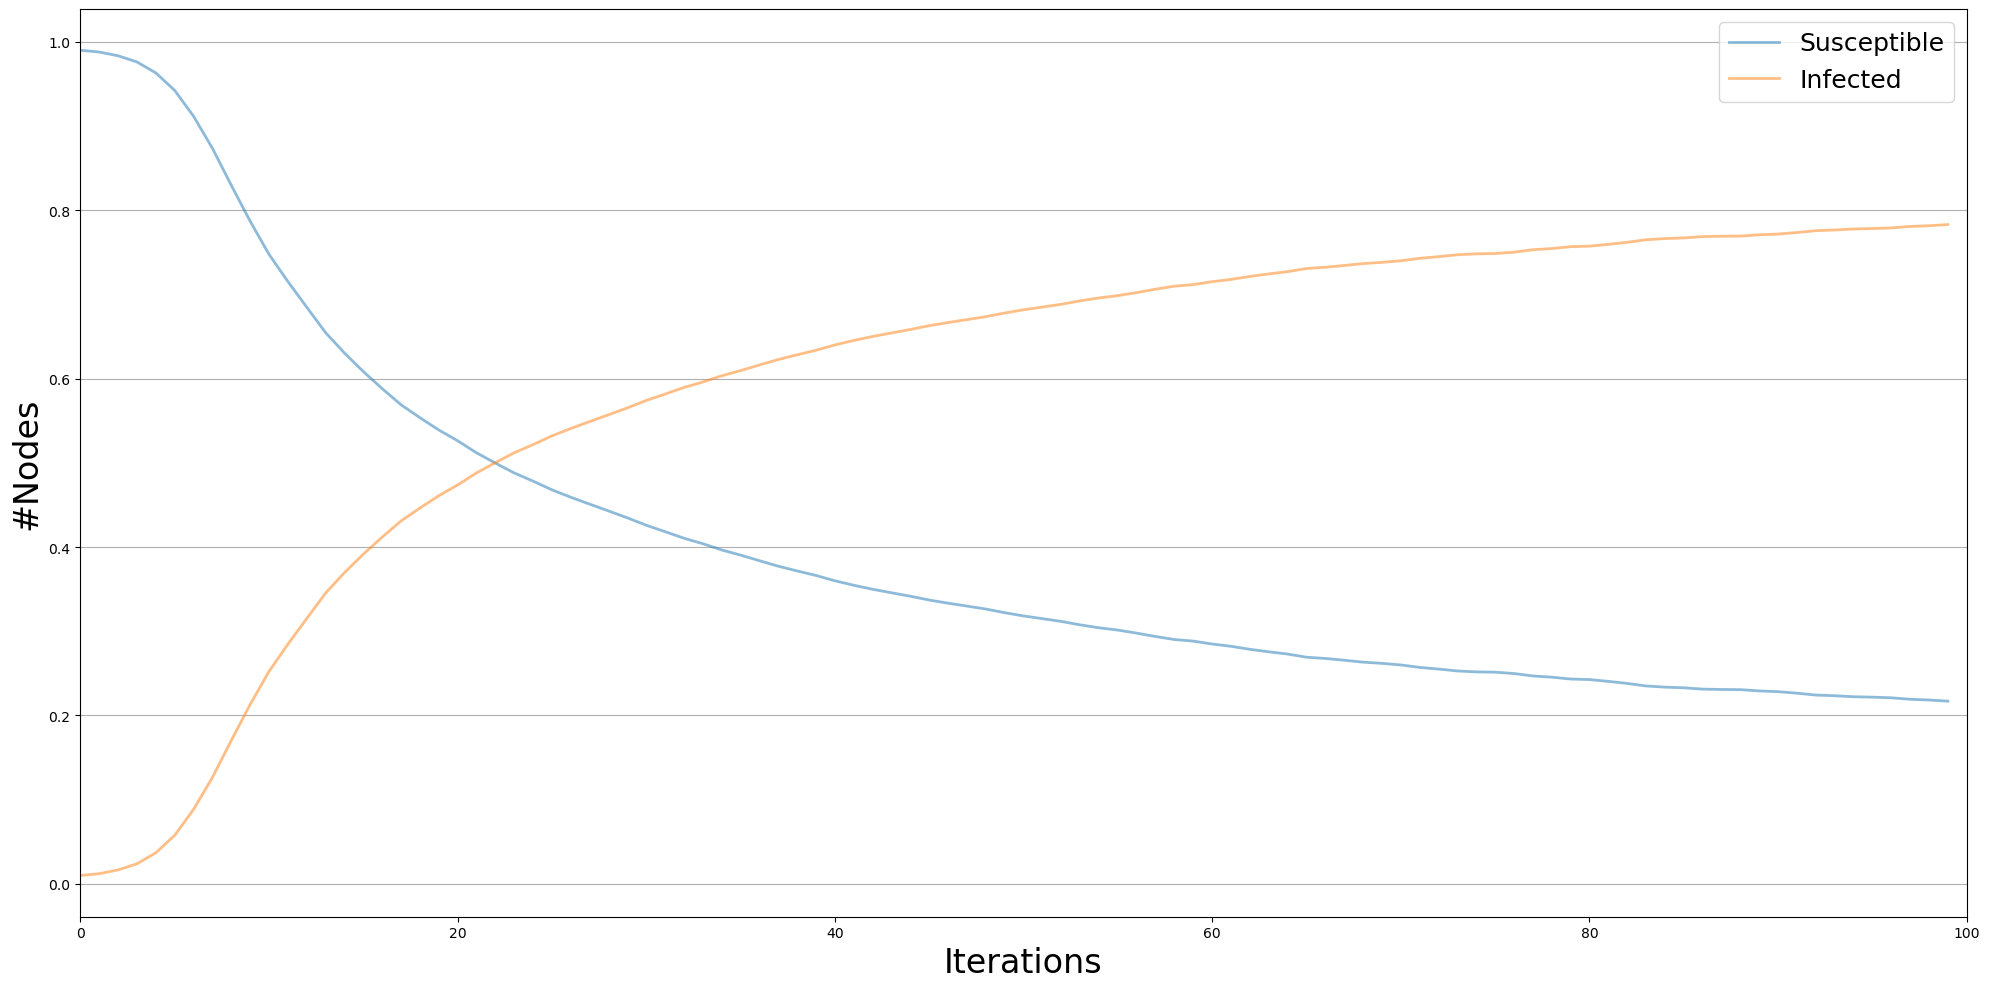

In [48]:
%matplotlib inline
viz = DiffusionTrend(model2, trends2)
viz.plot()

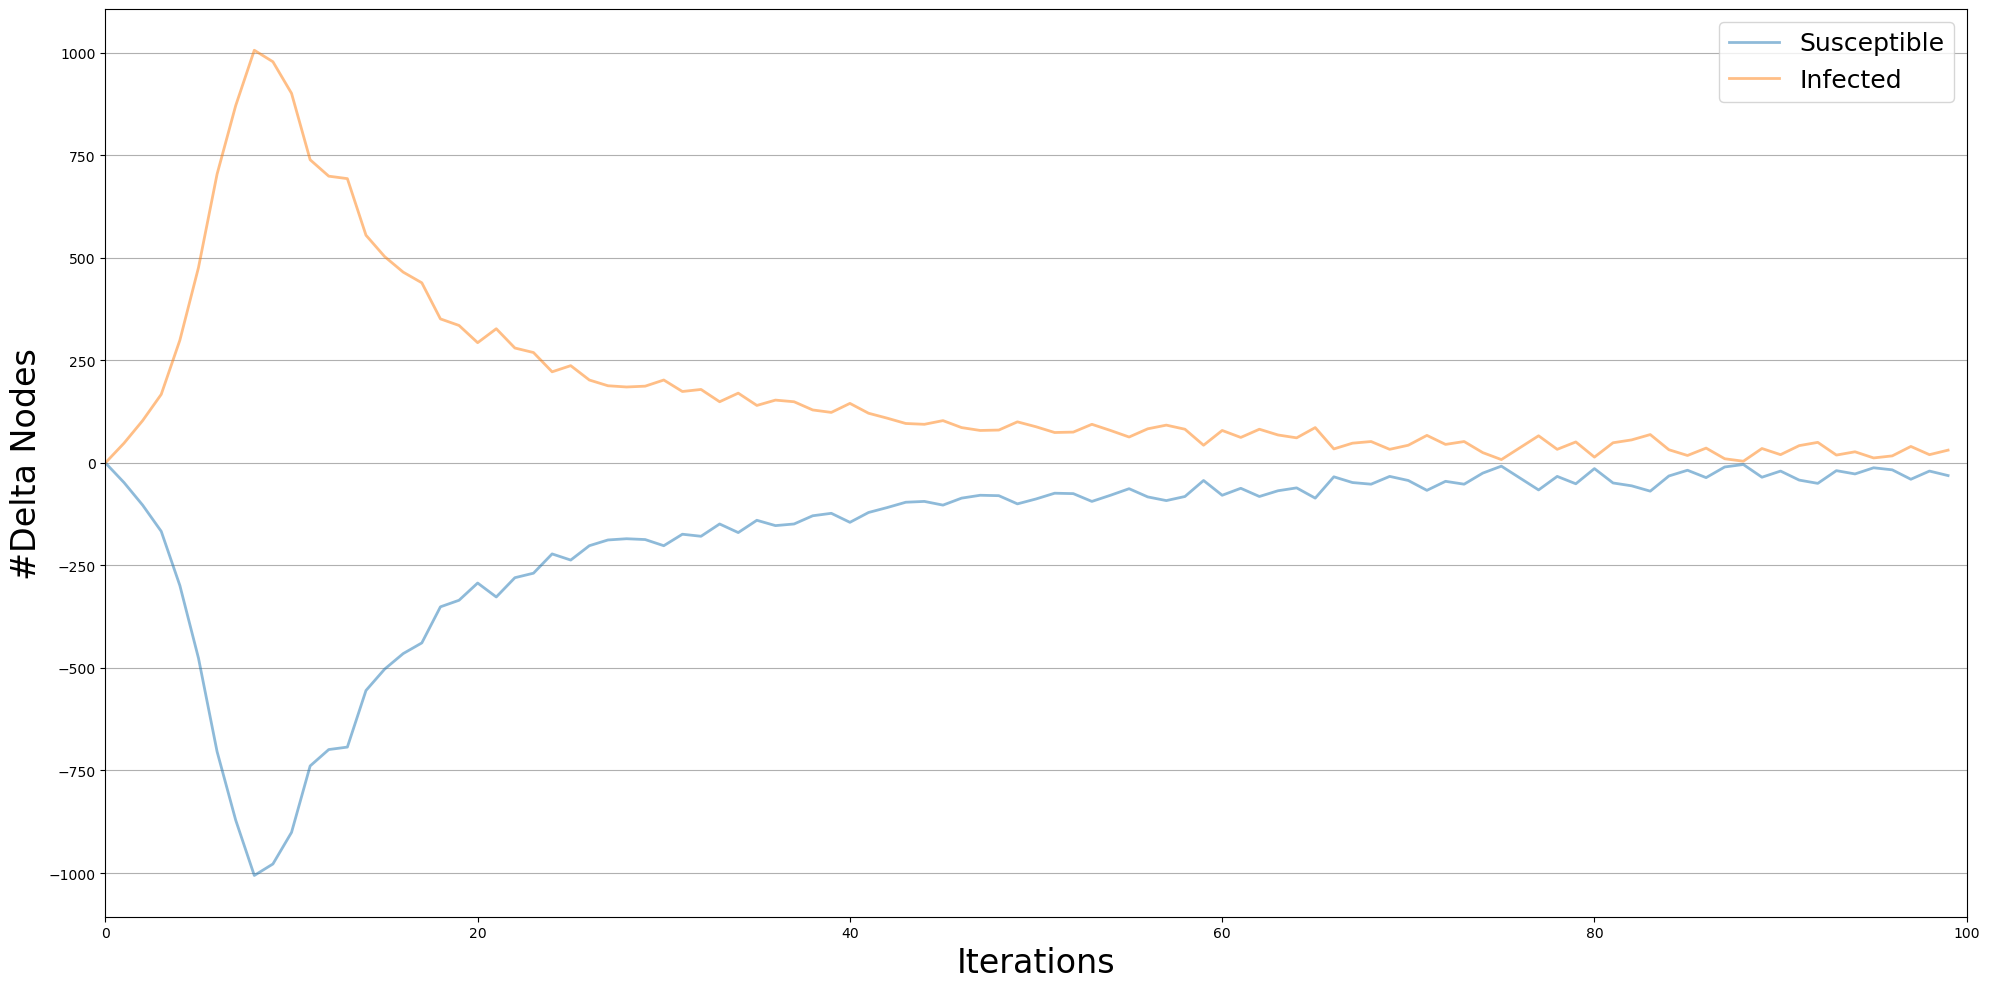

In [49]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model2, trends2)
viz.plot()

## SIR Model: 
Il terzo modello rappresenta invece uno scenario in cui, durante il tempo, il livello di influenza di un certo paper diminuisce, generando una progressiva decrescita di citazioni. 

In [50]:
model3 = ep.SIRModel(G)

In [51]:
model3.available_statuses

{'Susceptible': 0, 'Infected': 1, 'Removed': 2}

In [52]:
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) 
cfg.add_model_parameter('gamma', 0.01) 
cfg.add_model_parameter("percentage_infected", 0.01)
model3.set_initial_status(cfg)

In [53]:
iterations3 = model3.iteration_bunch(200, node_status=True)
trends3 = model3.build_trends(iterations3)

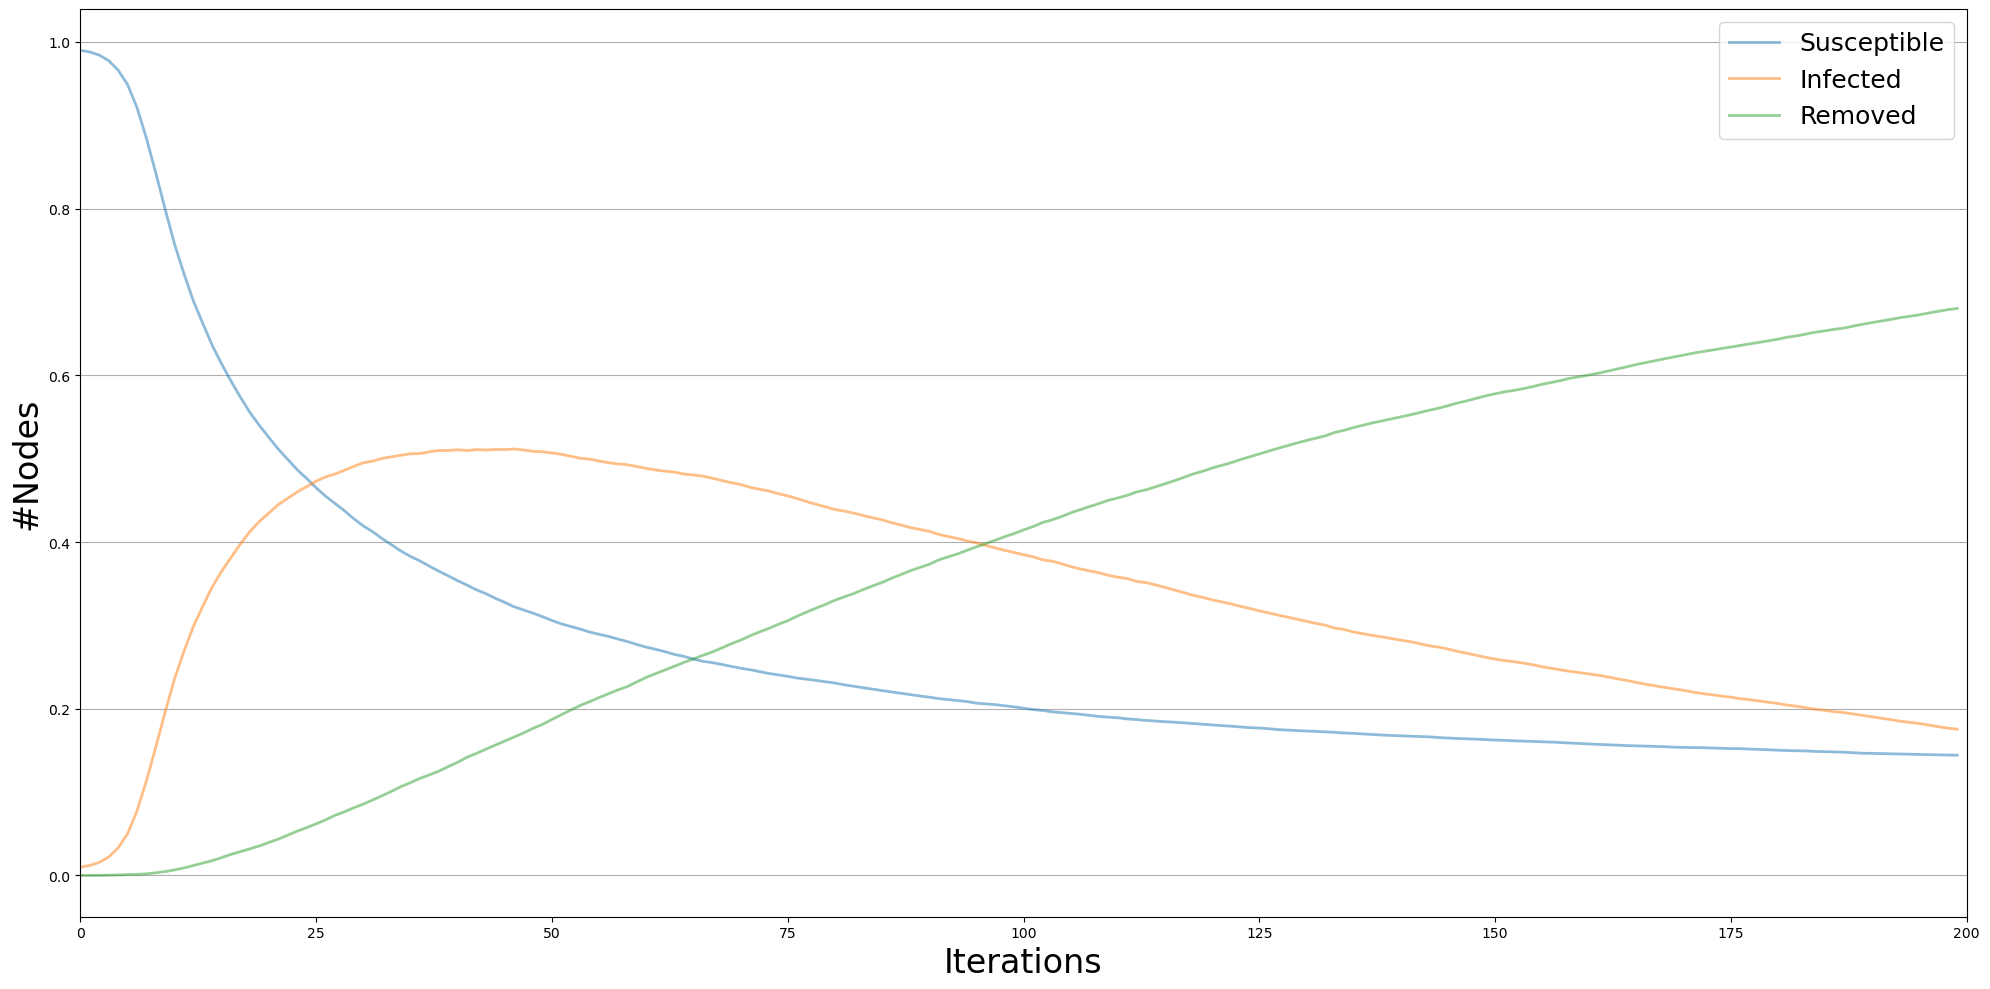

In [54]:
%matplotlib inline
viz = DiffusionTrend(model3, trends3)
viz.plot()

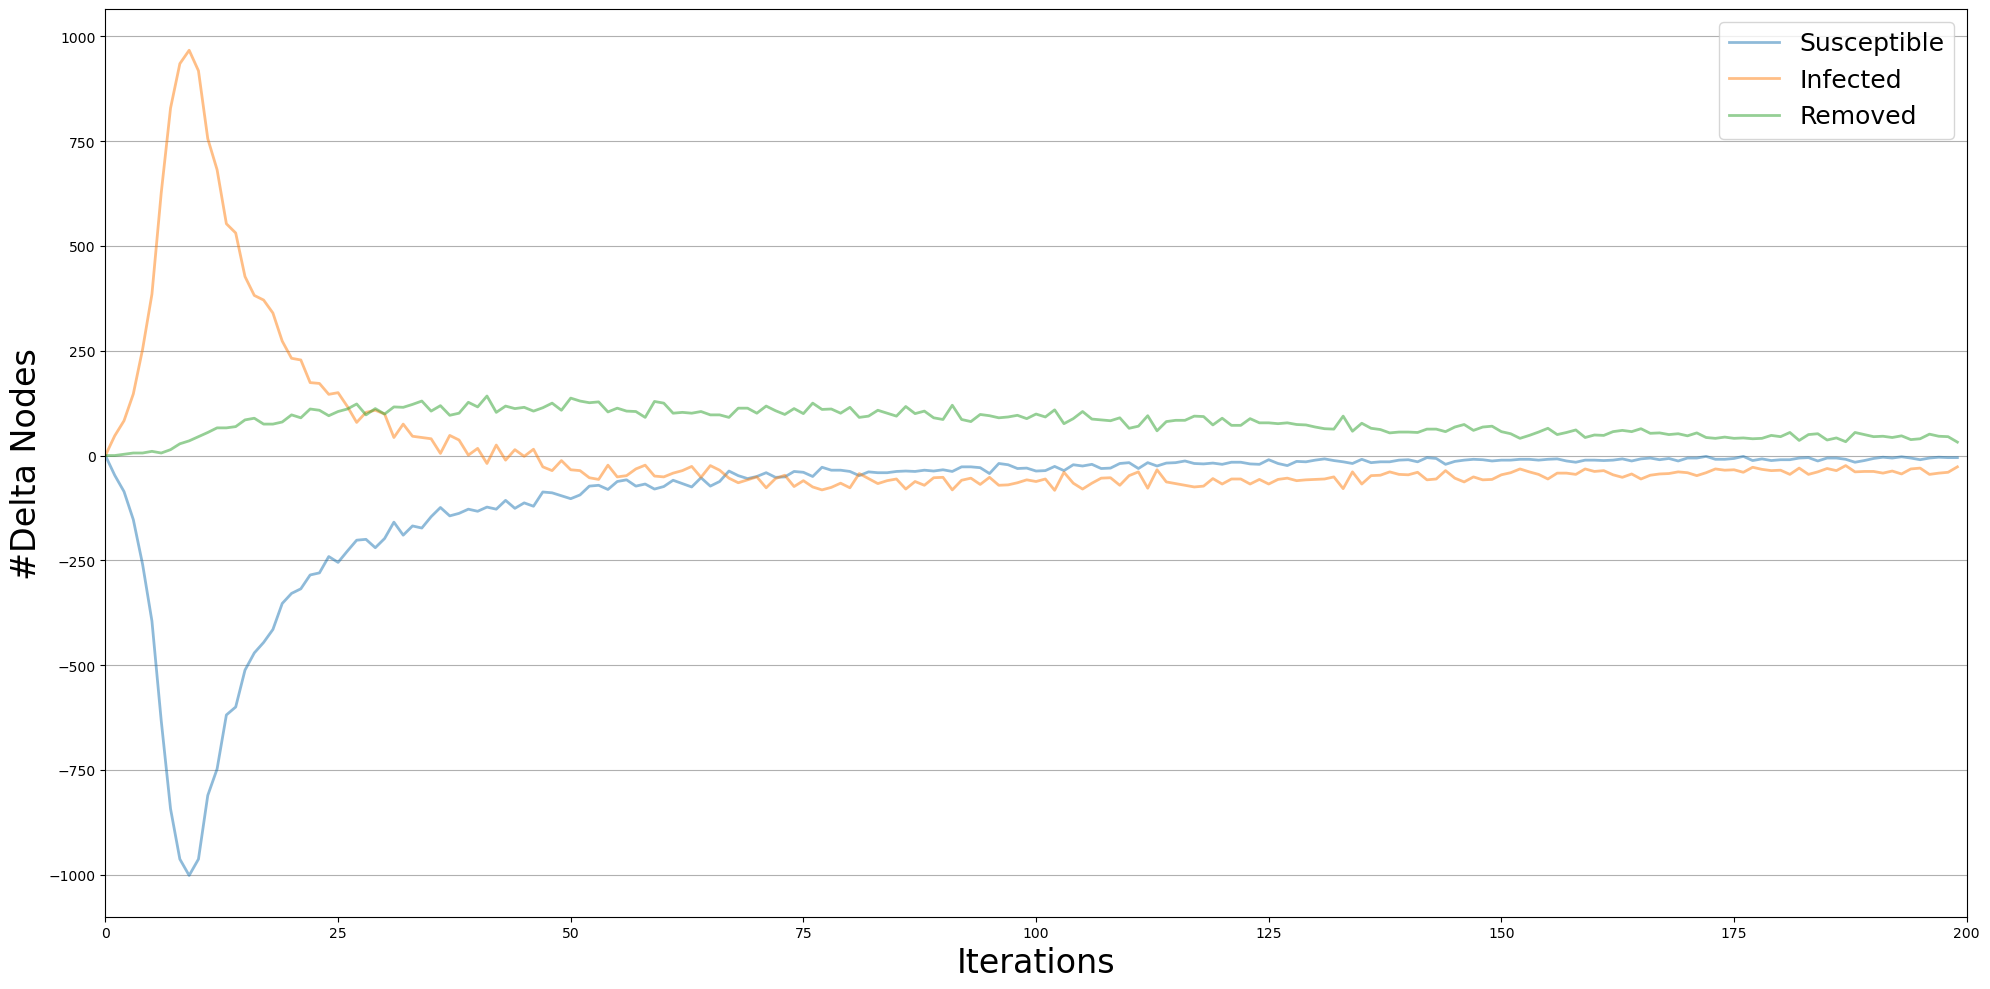

In [55]:
viz = DiffusionPrevalence(model3, trends3)
viz.plot()

## Test al variare di I per il modello SIR

In [56]:
def run_simulation(initial_infected, beta=0.001, gamma=0.1, percentage_infected=0.01, iterations_count=100):
    directory = f'frames_{initial_infected}'
    os.makedirs(directory, exist_ok=True)

    G = nx.erdos_renyi_graph(1000, 0.1)
    model = ep.SIRModel(G)

    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
   
    cfg.add_model_initial_configuration("Infected", list(range(initial_infected)))
    model.set_initial_status(cfg)

    iterations = model.iteration_bunch(iterations_count, node_status=True)
    trends = model.build_trends(iterations)

    for t in range(len(trends)):
        plt.figure()
        viz = DiffusionTrend(model, trends[:t+1])
        viz.plot()
        plt.savefig(f'{directory}/frame_{t:03d}.png')
        plt.close()

    frames = []
    for t in range(len(trends)):
        frames.append(imageio.imread(f'{directory}/frame_{t:03d}.png'))
    imageio.mimsave(f'infection_simulation_{initial_infected}.gif', frames, duration=0.1)

    shutil.rmtree(directory)


<Figure size 640x480 with 0 Axes>

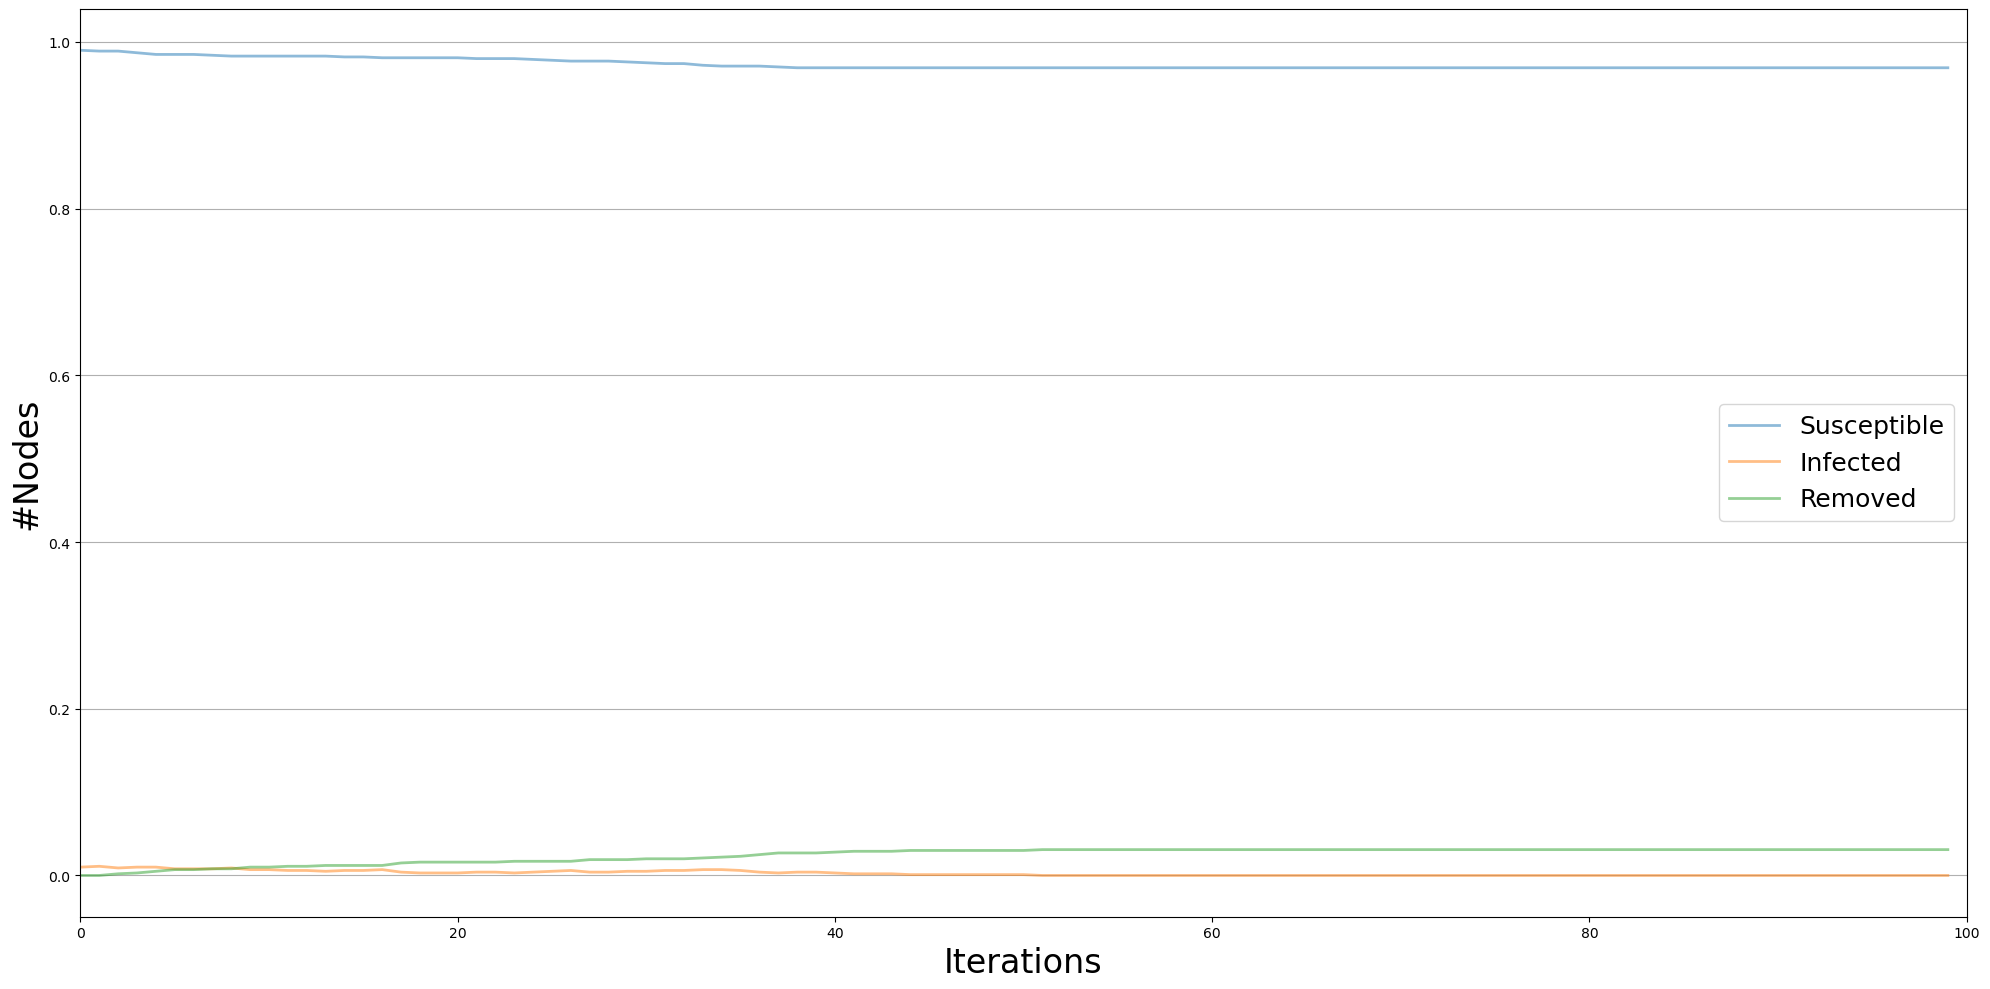

C:\Users\beatr\AppData\Local\Temp\ipykernel_39312\2318957162.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(f'{directory}/frame_{t:03d}.png'))


<Figure size 640x480 with 0 Axes>

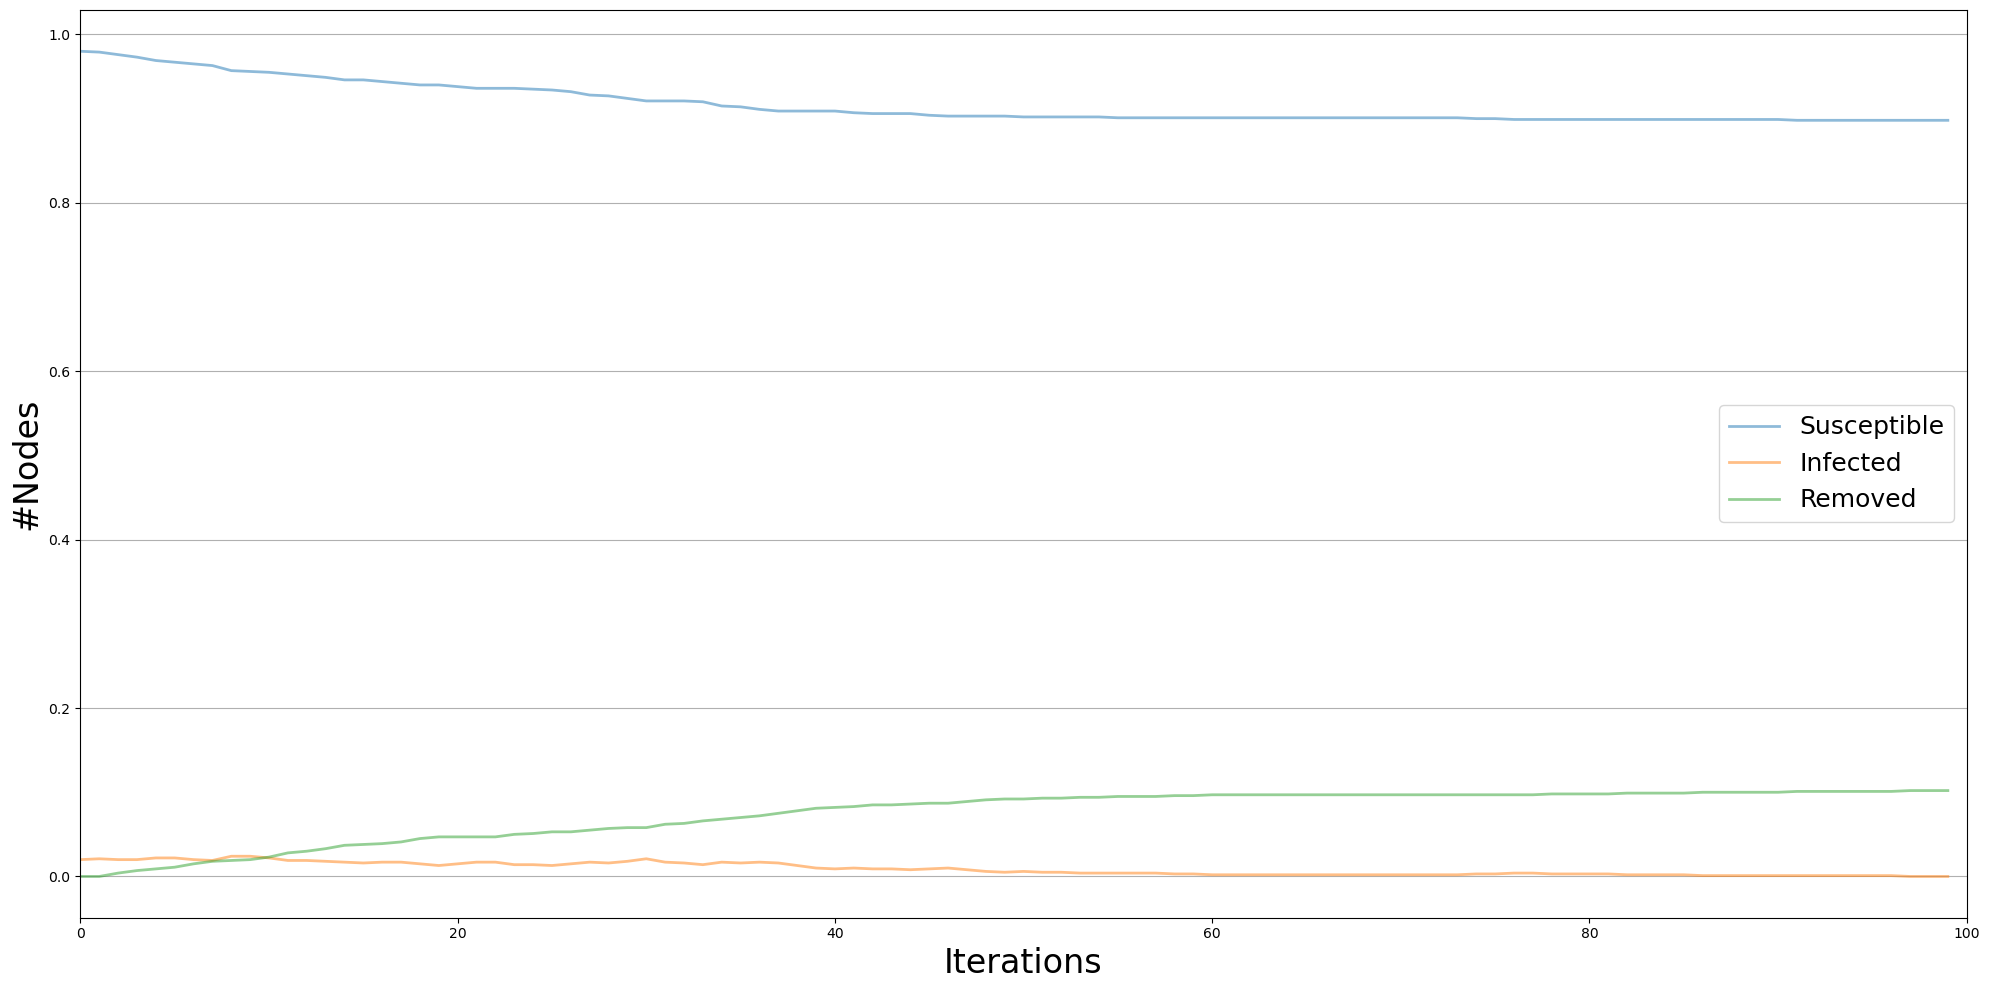

<Figure size 640x480 with 0 Axes>

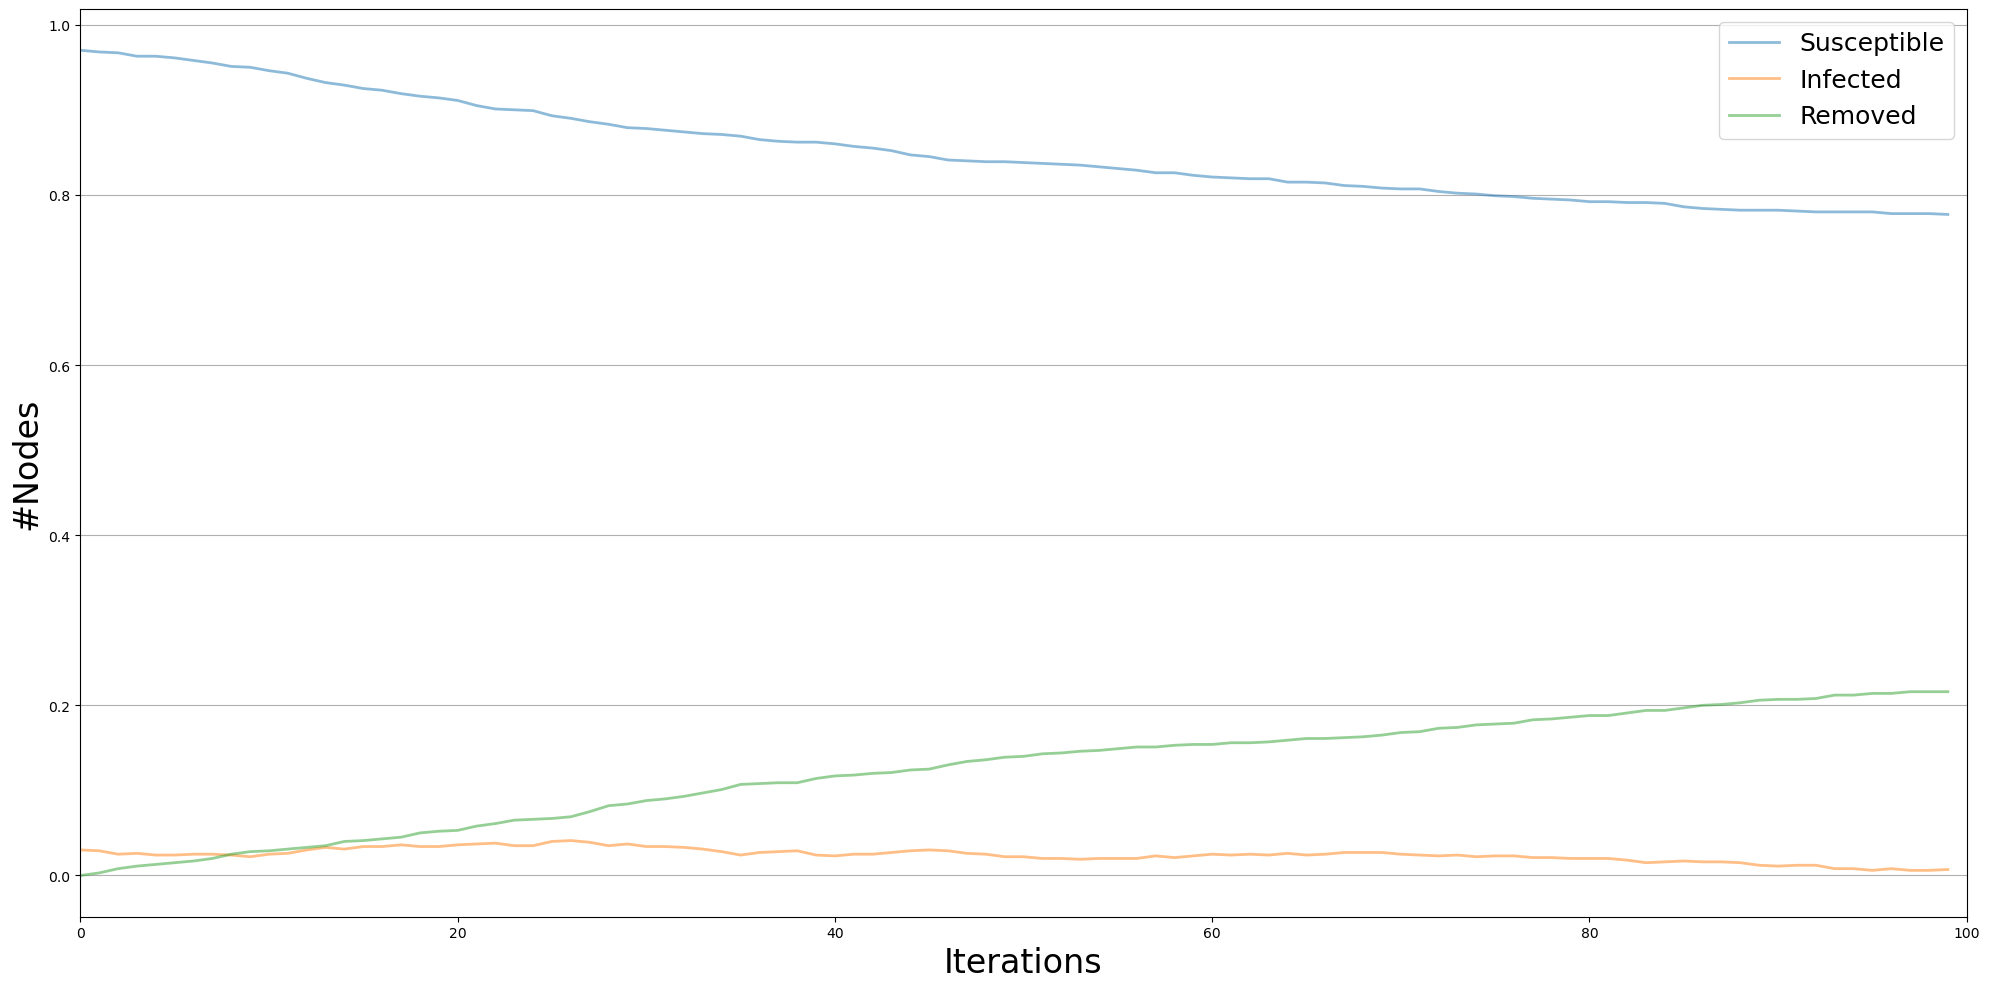

<Figure size 640x480 with 0 Axes>

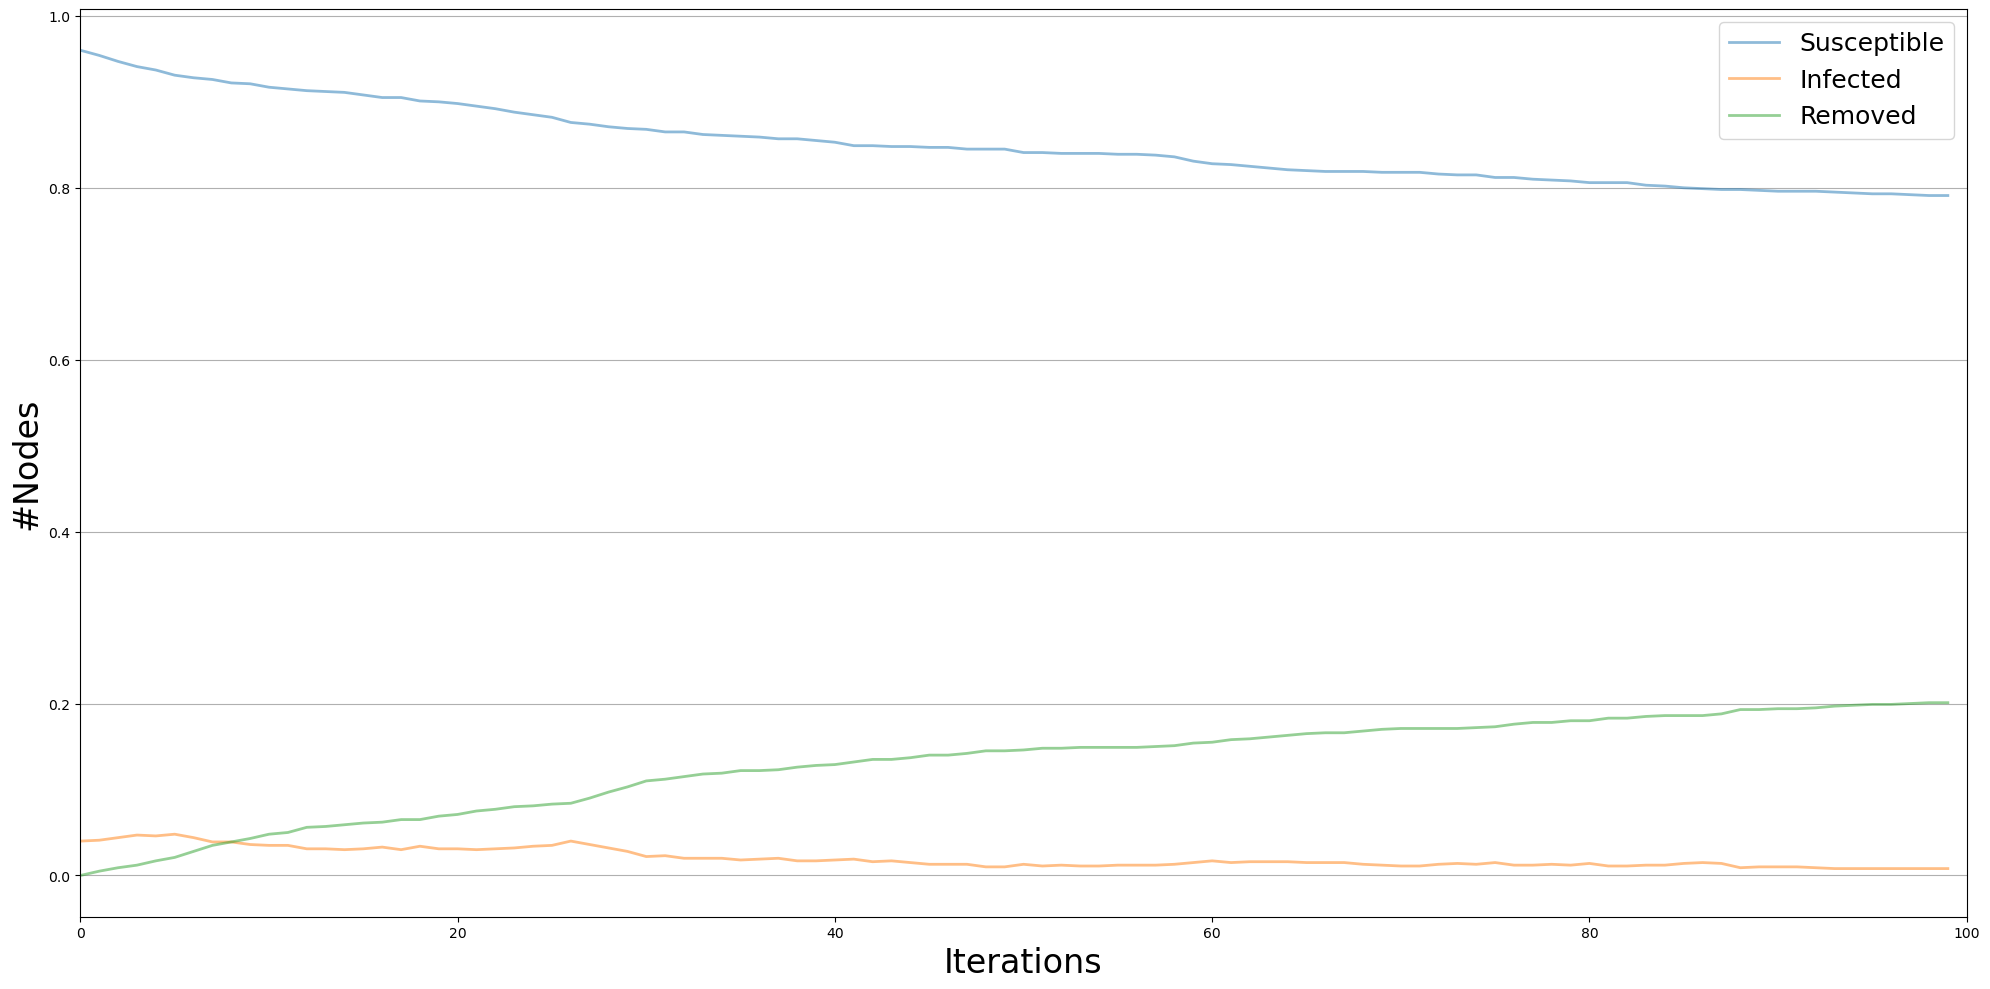

<Figure size 640x480 with 0 Axes>

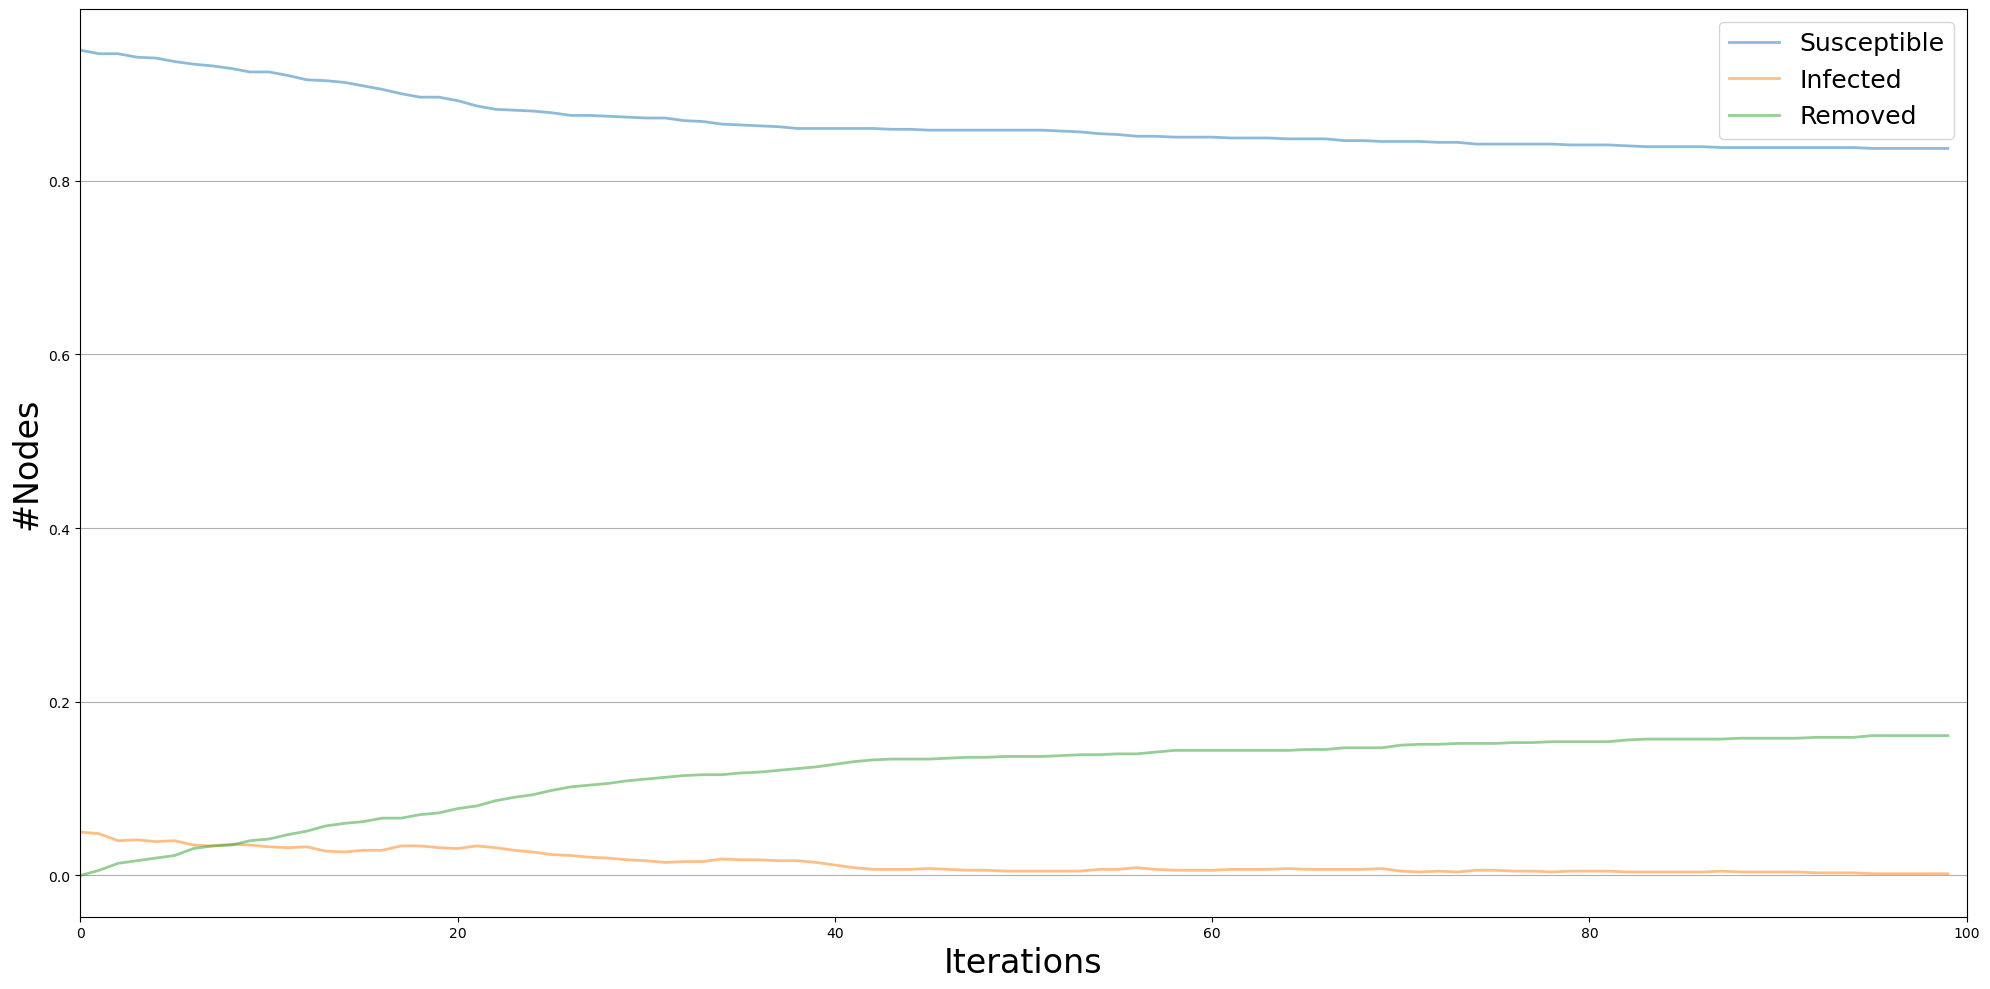

<Figure size 640x480 with 0 Axes>

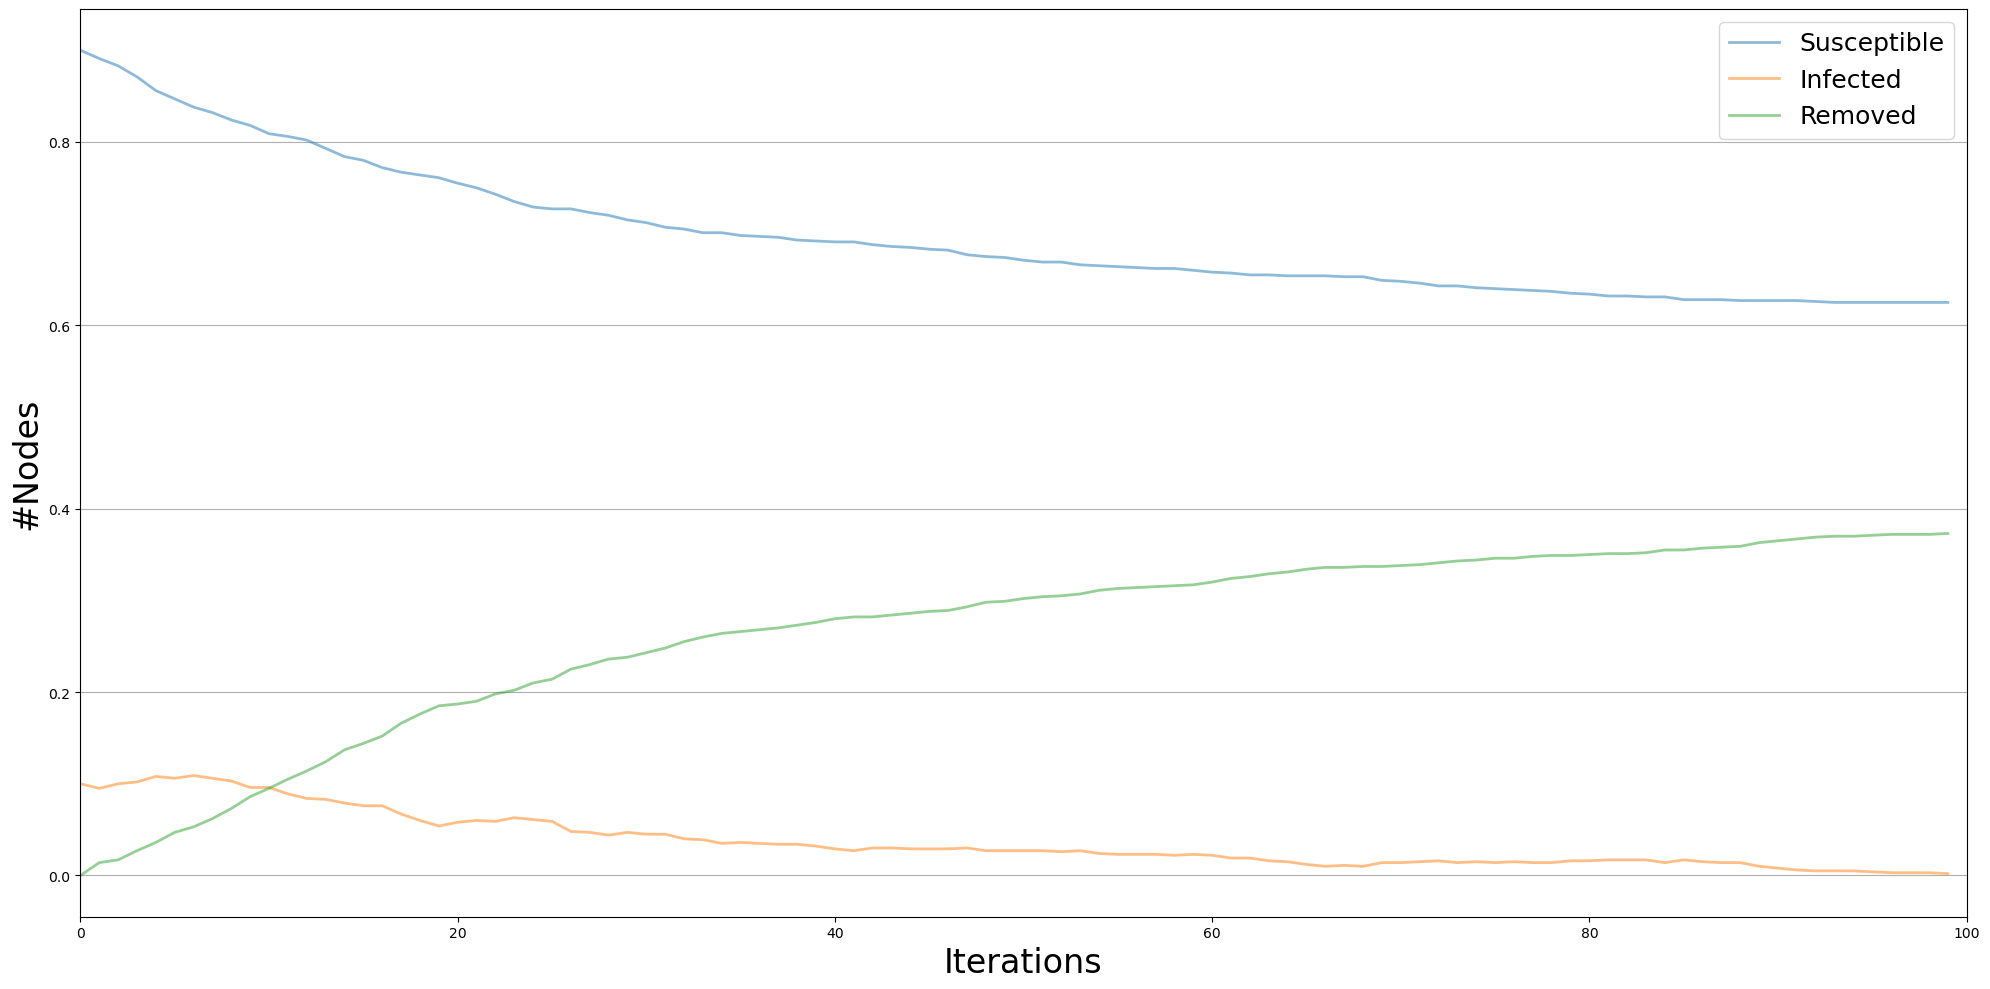

<Figure size 640x480 with 0 Axes>

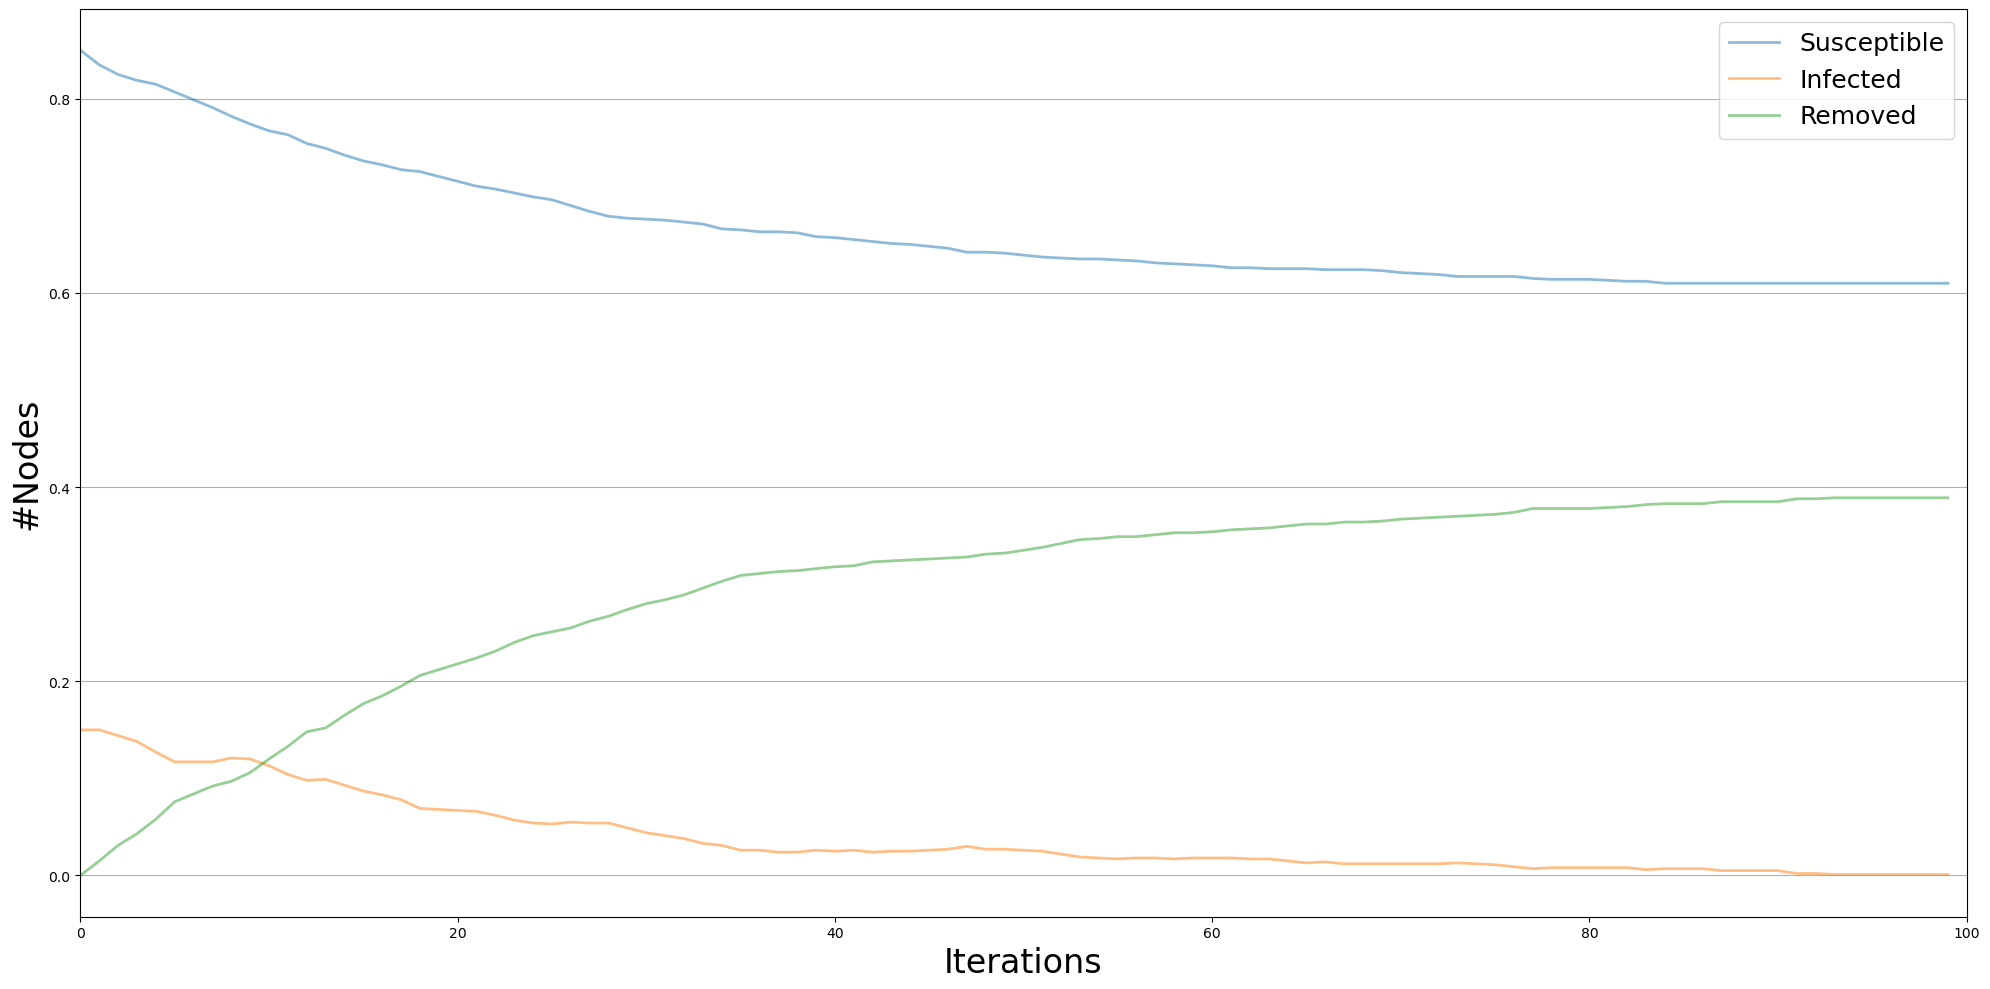

<Figure size 640x480 with 0 Axes>

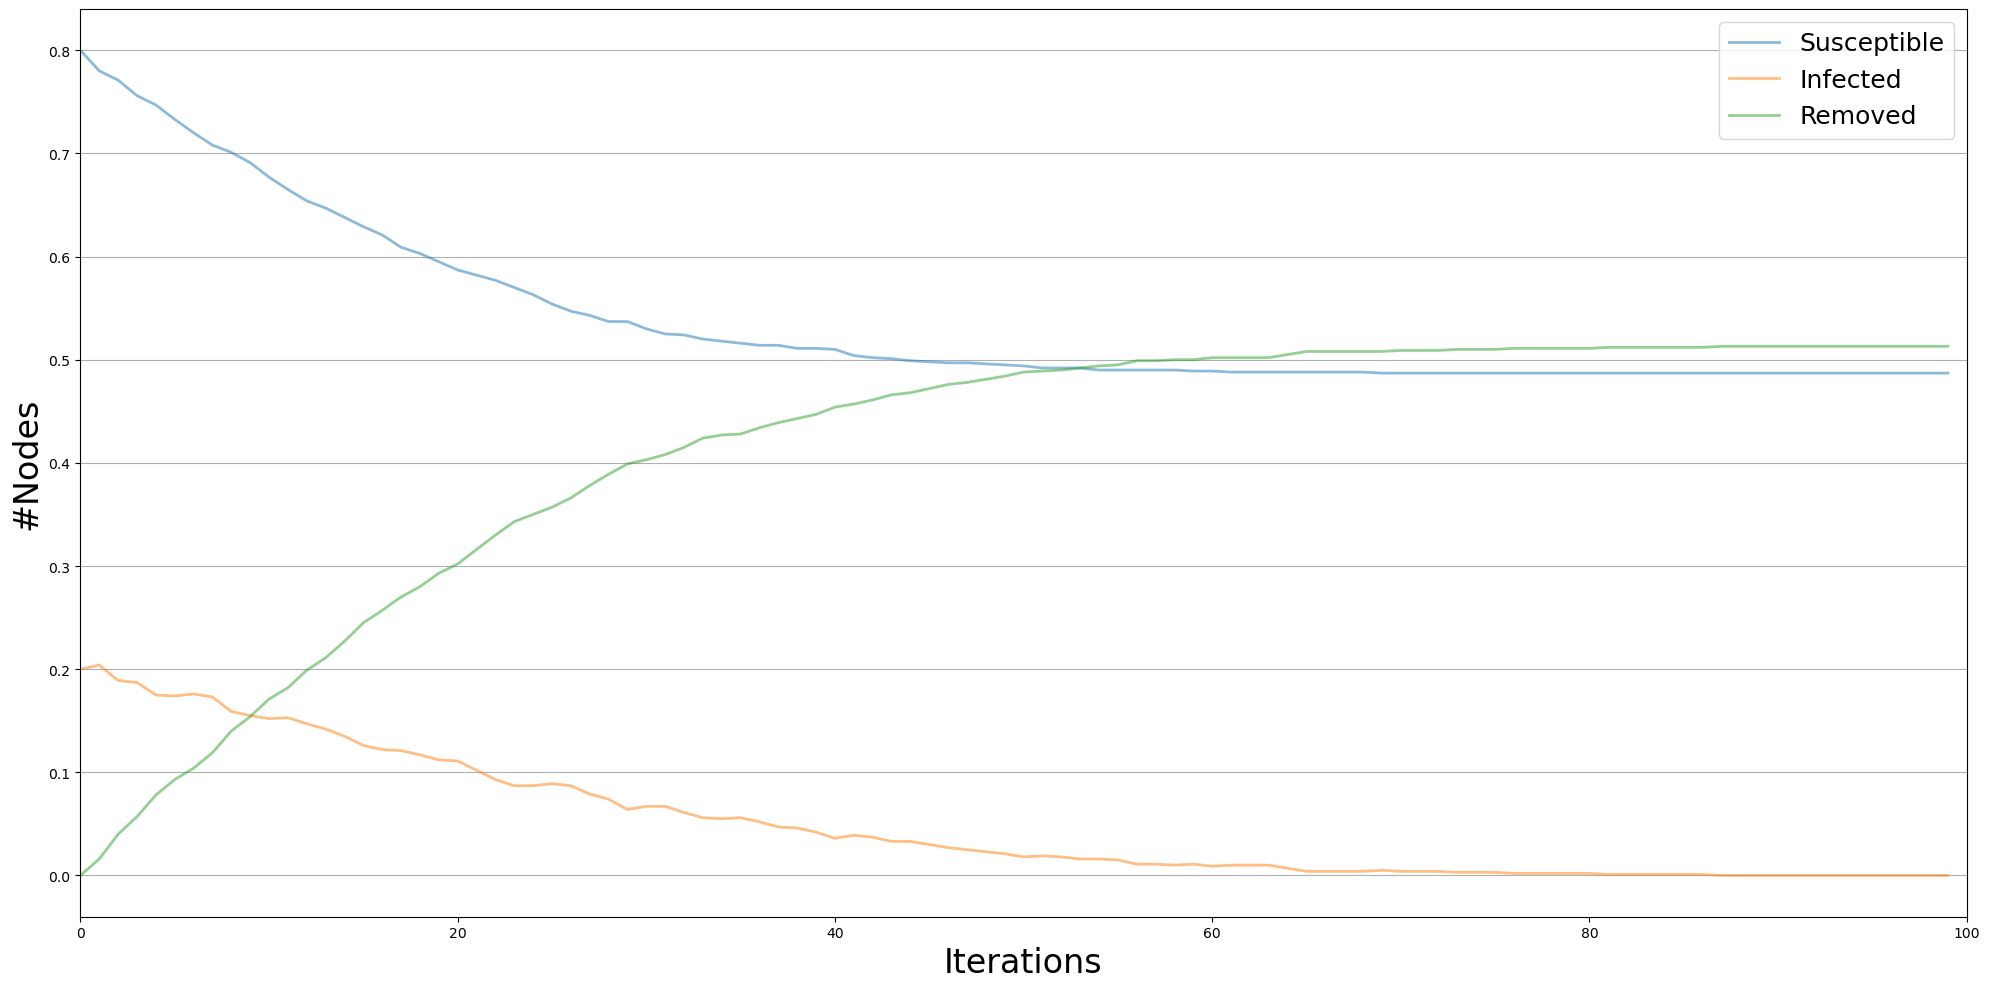

<Figure size 640x480 with 0 Axes>

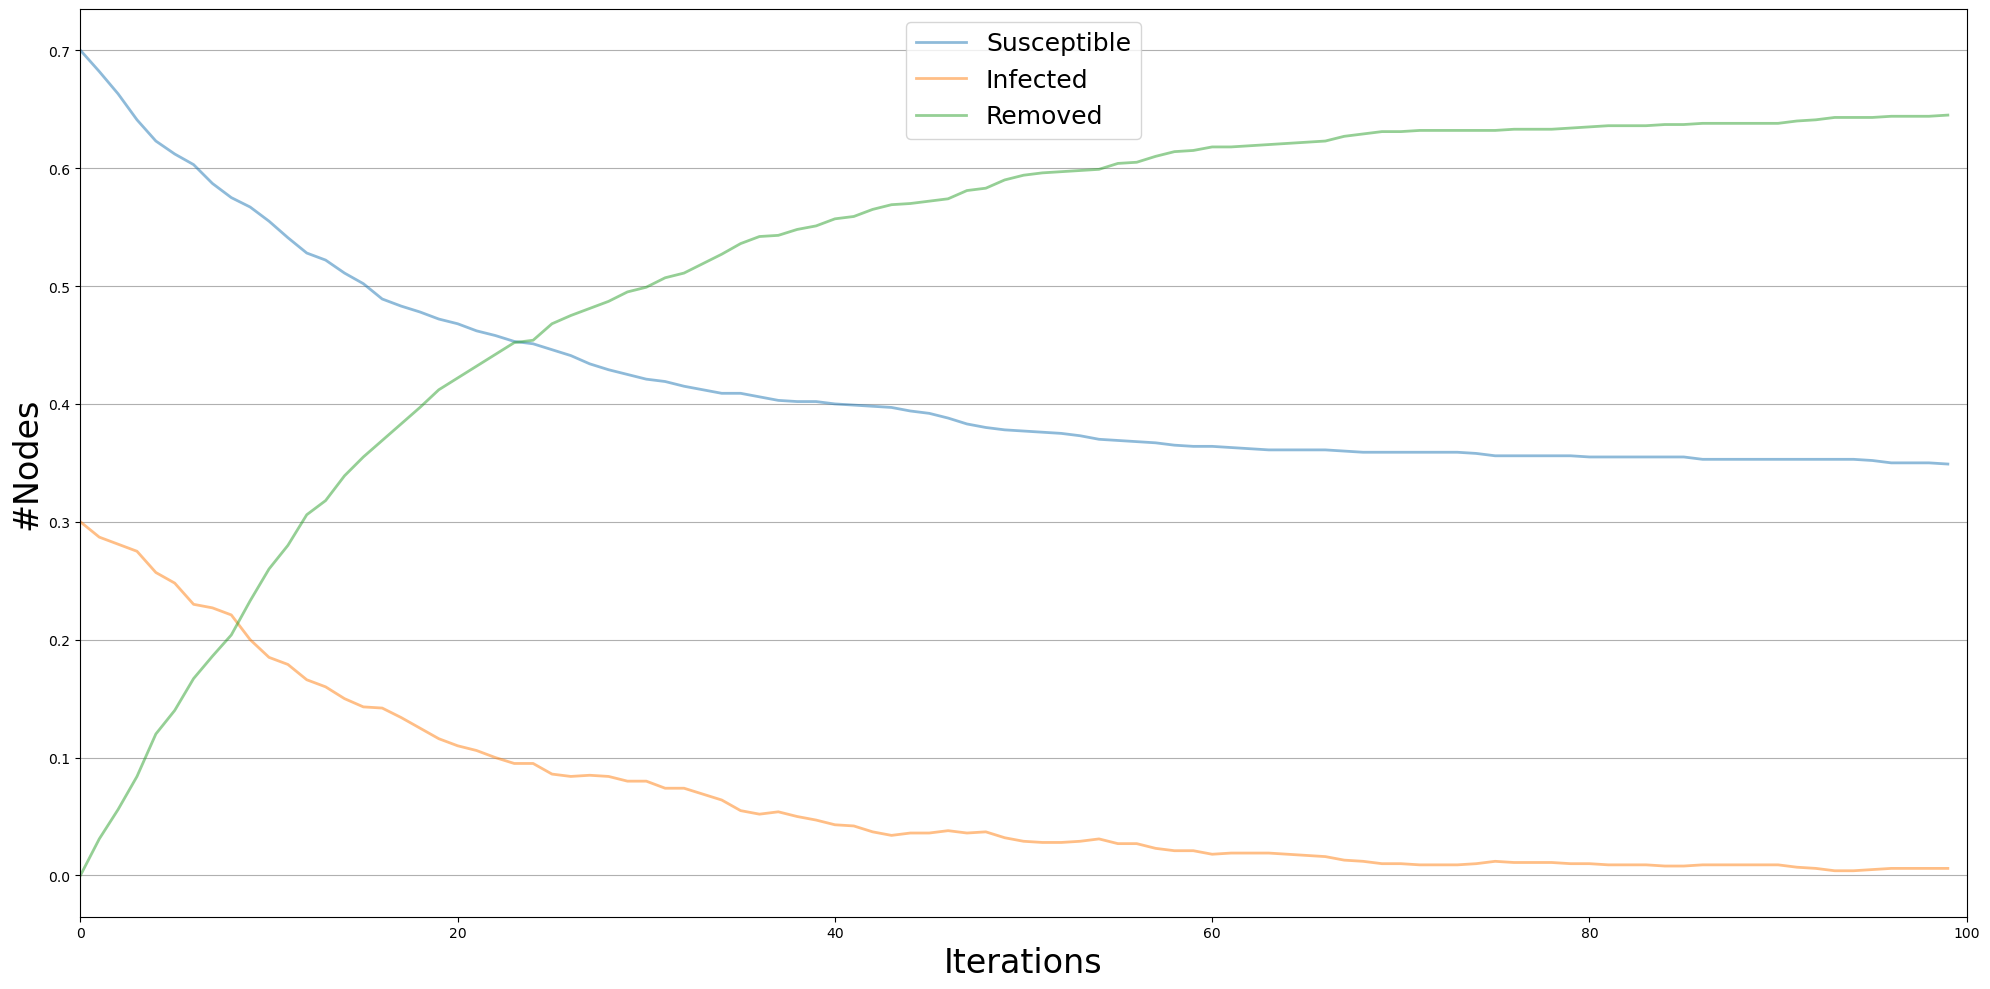

<Figure size 640x480 with 0 Axes>

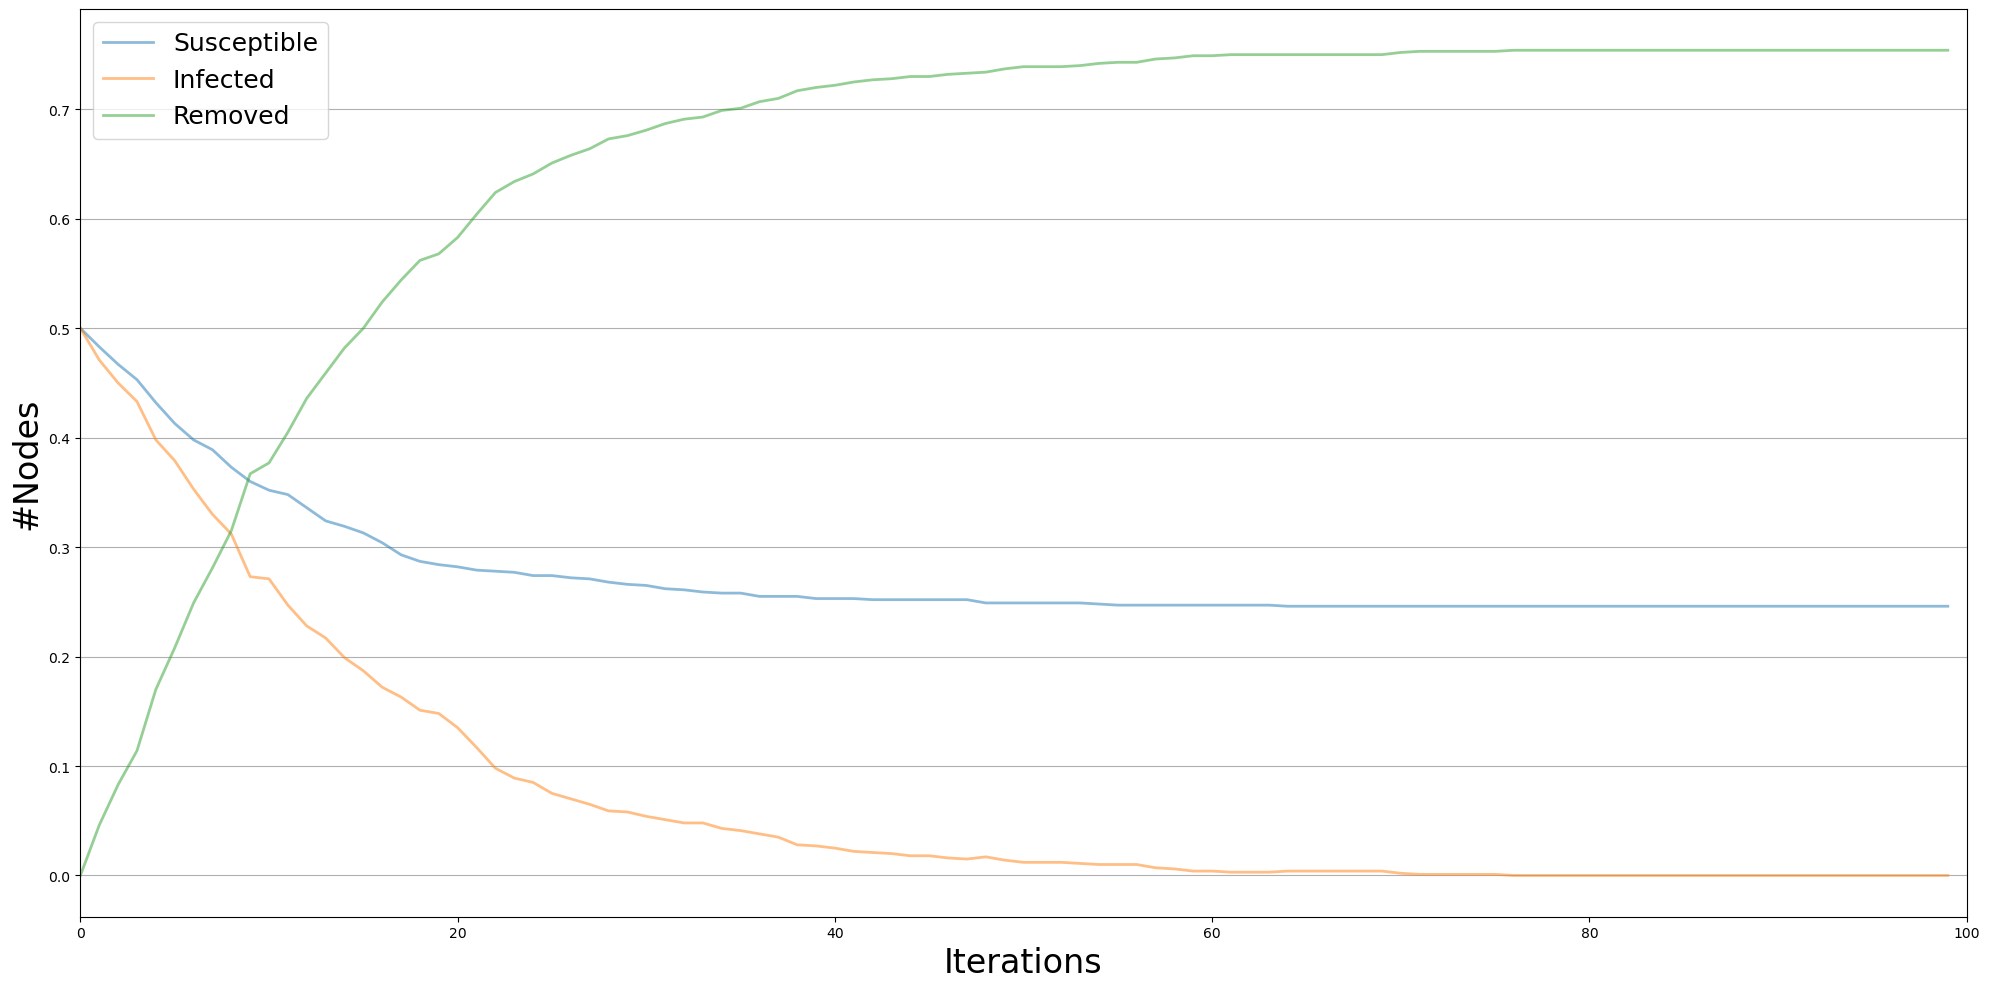

<Figure size 640x480 with 0 Axes>

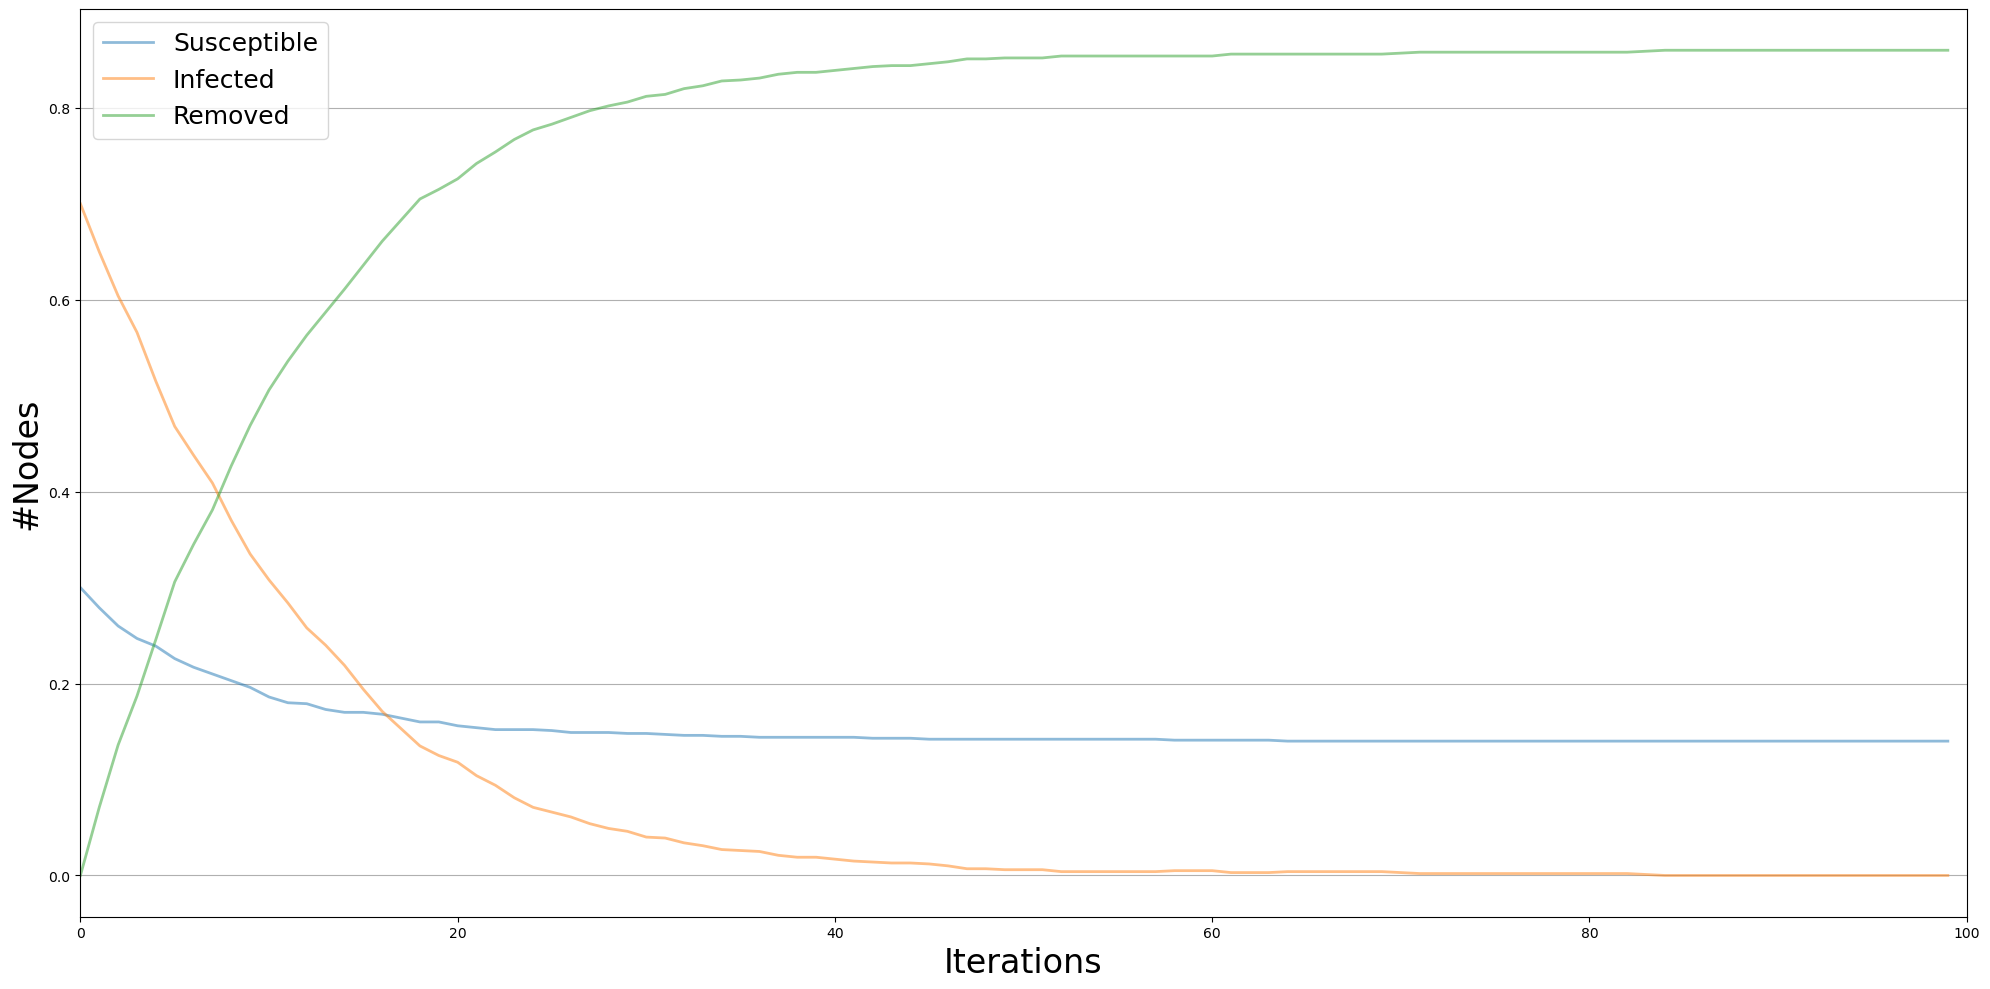

In [57]:
initial_infected_list = [10, 20, 30, 40, 50, 100, 150, 200, 300, 500, 700]

for initial_infected in initial_infected_list:
    run_simulation(initial_infected)

In [58]:
def run_simulation(initial_infected, total_population):
    days = 10
    infection_rate = 0.3  
    recovery_rate = 0.1   
    infected = initial_infected
    susceptible = total_population - initial_infected
    removed = 0
    results_S = [susceptible]
    results_I = [infected]
    results_R = [removed]
    
    for day in range(1, days + 1):
        new_infections = infection_rate * infected * susceptible / total_population
        new_recoveries = recovery_rate * infected
        
        susceptible -= new_infections
        infected += new_infections - new_recoveries
        removed += new_recoveries
        
        results_S.append(susceptible)
        results_I.append(infected)
        results_R.append(removed)
    
    return results_S, results_I, results_R

In [59]:
total_population = G.number_of_nodes()

In [60]:
for initial_infected in initial_infected_list:
    results_S, results_I, results_R = run_simulation(initial_infected, total_population)
    print(f"Initial infected: {initial_infected}")
    for day in range(len(results_S)):
        print(f"Day {day}: S={results_S[day]:.2f}, I={results_I[day]:.2f}, R={results_R[day]:.2f}")
    print()

Initial infected: 10
Day 0: S=22900.00, I=10.00, R=0.00
Day 1: S=22897.00, I=12.00, R=1.00
Day 2: S=22893.40, I=14.40, R=2.20
Day 3: S=22889.09, I=17.27, R=3.64
Day 4: S=22883.91, I=20.72, R=5.37
Day 5: S=22877.70, I=24.86, R=7.44
Day 6: S=22870.25, I=29.82, R=9.92
Day 7: S=22861.32, I=35.77, R=12.91
Day 8: S=22850.61, I=42.90, R=16.48
Day 9: S=22837.78, I=51.45, R=20.77
Day 10: S=22822.39, I=61.69, R=25.92

Initial infected: 20
Day 0: S=22890.00, I=20.00, R=0.00
Day 1: S=22884.01, I=23.99, R=2.00
Day 2: S=22876.81, I=28.79, R=4.40
Day 3: S=22868.19, I=34.53, R=7.28
Day 4: S=22857.85, I=41.42, R=10.73
Day 5: S=22845.45, I=49.67, R=14.87
Day 6: S=22830.60, I=59.56, R=19.84
Day 7: S=22812.79, I=71.42, R=25.80
Day 8: S=22791.45, I=85.61, R=32.94
Day 9: S=22765.90, I=102.60, R=41.50
Day 10: S=22735.32, I=122.92, R=51.76

Initial infected: 30
Day 0: S=22880.00, I=30.00, R=0.00
Day 1: S=22871.01, I=35.99, R=3.00
Day 2: S=22860.23, I=43.17, R=6.60
Day 3: S=22847.31, I=51.77, R=10.92
Day 4: S=

## Conclusioni

L'approccio epidemiologico si presta a interessanti riflessioni in merito al sistema di "quotations" nell'ambito della produzione scientifica tra gli anni ------ .

Dall'ultima simulazione emerge un quadro abbastanza rappresentativo delle dinamiche di citazioni: prima che ci siano richiamo al lavoro di altri è necessario avere un "initial infection" alto. 
Inoltre, dopo un'iniziale crescita, il numero di paper che contengono determinate citazioni diminuisce. 